In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np, pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import graphviz
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

In [274]:
class Preprocessing :
    #make linear regression model and fit, return linear regression model and score
    #df : dataframe
    #columns : columns list for make linear regression model
    #target : target feature name
    #test : train test split's test_size parameter
    #random= : train test split's random_state parameter
    #return : linear regression model and score
    def reg_score(self,df,columns,target,test = 0.2,random=0):
        t_col = columns.copy()
        t_col.append(target)
        data = df[t_col]
        clean_df = data.dropna(how="any")
        train_X, test_X, train_y, test_y = train_test_split(
            clean_df[columns],clean_df[target],test_size=test,random_state=random)
        linear = LinearRegression().fit(train_X,train_y)
        return linear,linear.score(test_X,test_y)
    
    #Return Scaled Dataframe
    #df : dataframe
    #method : scaling method (standard, minmax, maxabs, robust)
    #return : scaled dataframe
    def scaler(self,df,method = "std"):
        if method == "std" : 
            return (df - df.mean()) / df.std()
        elif method == "minmax" :
            return (df- df.min()) /(df.max() - df.min())
        elif method == "maxabs" :
            return df/df.abs().max()
        elif method == "robust" :
            return (df - df.median()) / (df.quantile(.75)-df.quantile(.25))
        else : 
            raise Exception("Scaling method input error.")
            
    #Return Scaled Dataframe Matrix
    #df : dataframe
    #return : scaled dataframe matrix, (0,0) = std, (0,1) = minmax, (1,0) = maxabs, (1,1) = robust           
    def scalerMatrix(self,df):
        return [[self.scaler(df,"std"),self.scaler(df,"minmax")],[self.scaler(df,"maxabs"),self.scaler(df,"robust")]]



def makeDecisionTree(citerion, x_train, y_train,depthNum):
    if depthNum>0:
        clf = tree.DecisionTreeClassifier(criterion=citerion, max_depth=depthNum)
    else:
        clf = tree.DecisionTreeClassifier(criterion=citerion)

    clf.fit(x_train, y_train)

    return clf

def printTreeGraph(model):
    dot_data = tree.export_graphviz(model,
                                    out_file=None,
                                    feature_names=feature_name,
                                    class_names=target_name,
                                    filled=True,
                                    rounded=True,
                                    special_characters=True)
    graph = graphviz.Source(dot_data)
    print(graph)


def foldValidatation(model,train_x,train_y,foldNum):
    cv_scores=cross_val_score(model,train_x,train_y,cv=foldNum)
    print(cv_scores)
    print("cv_scores mean: {}".format(np.mean(cv_scores)))
    # print(cross_validate(model, train_x, train_y, scoring=['accuracy', 'roc_auc'], return_train_score=True))

def treeGridSearch(x_train,y_train):
    tree_params = {
        "criterion": ["gini","entropy"],
        "splitter": ["best", "random"],
        "max_depth": [2, 6, 10, 14],
        "max_features": ["auto", "sqrt", "log2", 5, None]
    }
    tree_grid = GridSearchCV(tree.DecisionTreeClassifier(random_state=12),
                             tree_params,
                             scoring="neg_mean_squared_error",
                             verbose=1,
                             n_jobs=-1)
    tree_grid.fit(x_train, y_train)
    best_param=tree_grid.best_params_
    print("Best parameter(Decision Tree) : ")
    print(best_param)
    print("Best score(Decision Tree) : ")
    print(tree_grid.best_score_)

def baggingGridSearch(best_tree):
    bagging_params = {
        "n_estimators": [50, 100, 150],
        "max_samples": [0.25, 0.5, 1.0],
        "max_features": [0.25, 0.5, 1.0],
        "bootstrap": [True, False],
        "bootstrap_features": [True, False]
    }
    best_bagging = GridSearchCV(BaggingClassifier(best_tree),
                                   bagging_params,
                                   cv=4,
                                   verbose=1,
                                   n_jobs=-1)

    best_bagging.fit(train_x, train_y)
    print("Best parameter(Bagging) : ")
    print(best_bagging.best_params_)
    print("Best score(Bagging) : ")
    print(best_bagging.best_score_)

    print(foldValidatation(best_bagging, test_x, test_y, 3))

    # predict with train data and get score
    best_bagging.fit(train_x, train_y)
    best_pred = best_bagging.predict(train_x)

    print("------------train_score---------------")
    print(best_bagging.score(train_x, train_y))

    # predict with valid data and get score
    best_bagging.fit(valid_x, valid_y)
    best_pred = best_bagging.predict(valid_x)
    print("------------std_train_score---------------")
    print(best_bagging.score(valid_x, valid_y))

    # predict with test data and get score
    best_bagging.fit(test_x, test_y)
    best_pred = best_bagging.predict(test_x)
    print("------------std_test_score---------------")
    print(best_bagging.score(test_x, test_y))


def ordinalEncode_category(arr,str):
    enc=preprocessing.OrdinalEncoder()
    encodedData=enc.fit_transform(arr[[str]])
    column_name = str + " ordinalEncoded"
    arr[column_name] = encodedData
    return arr
    

In [3]:
#*****Data preprocessing*****

#load Air Pollution Datasets in Beijing
aotizhongxin = pd.read_csv("PRSA_Data_Aotizhongxin_20130301-20170228.csv")
changping = pd.read_csv("PRSA_Data_Changping_20130301-20170228.csv")
dingling = pd.read_csv("PRSA_Data_Dingling_20130301-20170228.csv")
dongsi = pd.read_csv("PRSA_Data_Dongsi_20130301-20170228.csv")
guanyuan = pd.read_csv("PRSA_Data_Guanyuan_20130301-20170228.csv")
gucheng = pd.read_csv("PRSA_Data_Gucheng_20130301-20170228.csv")
huairou = pd.read_csv("PRSA_Data_huairou_20130301-20170228.csv")
nongzhanguan = pd.read_csv("PRSA_Data_Nongzhanguan_20130301-20170228.csv")
shunyi = pd.read_csv("PRSA_Data_Shunyi_20130301-20170228.csv")
tiantan = pd.read_csv("PRSA_Data_Tiantan_20130301-20170228.csv")
wanliu = pd.read_csv("PRSA_Data_Wanliu_20130301-20170228.csv")
wanshouxigong = pd.read_csv("PRSA_Data_Wanshouxigong_20130301-20170228.csv")

#load Air Pollution and Weather Datasets in Seoul
seoul = pd.read_csv("seoul_air_20130301-20170228.csv")
weather = pd.read_csv("weather.csv")

In [4]:
#*Data restructuring
#Merging Beijing Datasets
beijing = pd.concat([aotizhongxin,changping,dingling,dongsi,
                     guanyuan,gucheng,huairou,nongzhanguan,
                     shunyi,tiantan,wanliu,wanshouxigong],ignore_index = True)

beijing.info()
beijing.describe()


#Drop No column
beijing.drop(columns="No",inplace = True)

beijing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 57.8+ MB


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
count,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,412029.000000,414319.000000,411747.000000,408652.000000,400067.000000,407491.000000,420370.000000,420375.000000,420365.000000,420378.000000,420450.000000
mean,17532.500000,2014.662560,6.522930,15.729637,11.500000,79.793428,104.602618,15.830835,50.638586,1230.766454,57.372271,13.538976,1010.746982,2.490822,0.064476,1.729711
std,10122.116943,1.177198,3.448707,8.800102,6.922195,80.822391,91.772426,21.650603,35.127912,1160.182716,56.661607,11.436139,10.474055,13.793847,0.821004,1.246386
min,1.000000,2013.000000,1.000000,1.000000,0.000000,2.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,0.000000
25%,8766.750000,2014.000000,4.000000,8.000000,5.750000,20.000000,36.000000,3.000000,23.000000,500.000000,11.000000,3.100000,1002.300000,-8.900000,0.000000,0.900000
50%,17532.500000,2015.000000,7.000000,16.000000,11.500000,55.000000,82.000000,7.000000,43.000000,900.000000,45.000000,14.500000,1010.400000,3.100000,0.000000,1.400000
75%,26298.250000,2016.000000,10.000000,23.000000,17.250000,111.000000,145.000000,20.000000,71.000000,1500.000000,82.000000,23.300000,1019.000000,15.100000,0.000000,2.200000
max,35064.000000,2017.000000,12.000000,31.000000,23.000000,999.000000,999.000000,500.000000,290.000000,10000.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,13.200000


,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4,Wanshouxigong
420764,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Wanshouxigong
420765,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1,Wanshouxigong
420766,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Wanshouxigong


In [5]:
#change year, month, day, hour columns to date format 
tt = pd.DataFrame(pd.date_range("2013-03-01","2017-03-01",freq="h"))
tt = tt[:-1]
tt = pd.concat([tt,tt,tt,tt,tt,tt,tt,tt,tt,tt,tt,tt],ignore_index = True)
beijing["Date"] = tt
#drop year, month, day, hour columns 
beijing.drop(columns=["year","month","day","hour"],inplace=True)

In [6]:
beijing


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,Date
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,2013-03-01 00:00:00
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,2013-03-01 01:00:00
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,2013-03-01 02:00:00
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,2013-03-01 03:00:00
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,2013-03-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4,Wanshouxigong,2017-02-28 19:00:00
420764,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Wanshouxigong,2017-02-28 20:00:00
420765,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1,Wanshouxigong,2017-02-28 21:00:00
420766,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Wanshouxigong,2017-02-28 22:00:00


In [7]:
beijing.info()
seoul.info()
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 14 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   PM2.5    412029 non-null  float64       
 1   PM10     414319 non-null  float64       
 2   SO2      411747 non-null  float64       
 3   NO2      408652 non-null  float64       
 4   CO       400067 non-null  float64       
 5   O3       407491 non-null  float64       
 6   TEMP     420370 non-null  float64       
 7   PRES     420375 non-null  float64       
 8   DEWP     420365 non-null  float64       
 9   RAIN     420378 non-null  float64       
 10  wd       418946 non-null  object        
 11  WSPM     420450 non-null  float64       
 12  station  420768 non-null  object        
 13  Date     420768 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(11), object(2)
memory usage: 44.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872901 entries, 0 to 872900
Da

In [8]:
weather
seoul

,tm,avgTa,sumRn,avgWs,maxWd,avgTd,minRhm,sumGsr,avgTs
0,2013-03-01,0.8,3.0,4.8,270.0,-7.3,35,15.28,3.5
1,2013-03-02,-0.8,NaN,3.2,270.0,-12.2,29,14.67,2.1
2,2013-03-03,0.4,NaN,2.9,270.0,-9.4,26,16.46,3.3
3,2013-03-04,3.1,NaN,2.8,290.0,-4.6,24,10.62,3.6
4,2013-03-05,3.7,NaN,3.0,230.0,-5.9,23,15.92,5.2
...,...,...,...,...,...,...,...,...,...
1456,2017-02-24,-0.8,NaN,2.2,270.0,-10.3,22,14.28,1.5
1457,2017-02-25,2.6,NaN,2.3,200.0,-4.3,32,15.11,3.2
1458,2017-02-26,3.6,NaN,2.1,270.0,-6.5,19,14.97,4.0
1459,2017-02-27,3.7,NaN,1.8,270.0,-10.1,18,15.89,4.2


,MSRDT,MSRSTE_NM,NO2,O3,CO,SO2,PM10,PM25
0,201303012300,영등포구,0.021,0.030,0.7,0.005,45.0,20.0
1,201303012300,성북구,0.014,0.034,0.3,0.004,38.0,15.0
2,201303012300,동대문구,0.016,0.033,0.4,0.006,38.0,18.0
3,201303012300,구로구,0.021,0.027,0.4,0.005,43.0,21.0
4,201303012300,강서구,0.018,0.035,0.3,0.006,43.0,17.0
...,...,...,...,...,...,...,...,...
872896,201702280000,종로구,0.063,0.002,0.7,0.004,29.0,18.0
872897,201702280000,강동구,0.064,0.002,0.7,0.005,37.0,23.0
872898,201702280000,중구,0.060,0.003,0.4,0.004,22.0,14.0
872899,201702280000,강남구,0.053,0.006,0.4,0.006,34.0,21.0


In [9]:
#change MSRDT column to date format 
date_s = seoul["MSRDT"].astype(str)
seoul["MSRDT"] = date_s.apply(lambda x: datetime.strptime(x, "%Y%m%d%H%M"))
seoul

,MSRDT,MSRSTE_NM,NO2,O3,CO,SO2,PM10,PM25
0,2013-03-01 23:00:00,영등포구,0.021,0.030,0.7,0.005,45.0,20.0
1,2013-03-01 23:00:00,성북구,0.014,0.034,0.3,0.004,38.0,15.0
2,2013-03-01 23:00:00,동대문구,0.016,0.033,0.4,0.006,38.0,18.0
3,2013-03-01 23:00:00,구로구,0.021,0.027,0.4,0.005,43.0,21.0
4,2013-03-01 23:00:00,강서구,0.018,0.035,0.3,0.006,43.0,17.0
...,...,...,...,...,...,...,...,...
872896,2017-02-28 00:00:00,종로구,0.063,0.002,0.7,0.004,29.0,18.0
872897,2017-02-28 00:00:00,강동구,0.064,0.002,0.7,0.005,37.0,23.0
872898,2017-02-28 00:00:00,중구,0.060,0.003,0.4,0.004,22.0,14.0
872899,2017-02-28 00:00:00,강남구,0.053,0.006,0.4,0.006,34.0,21.0


In [10]:
weather["tm"] = weather["tm"].apply(lambda _: datetime.strptime(_,"%Y-%m-%d"))
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   tm      1461 non-null   datetime64[ns]
 1   avgTa   1461 non-null   float64       
 2   sumRn   555 non-null    float64       
 3   avgWs   1461 non-null   float64       
 4   maxWd   1459 non-null   float64       
 5   avgTd   1461 non-null   float64       
 6   minRhm  1461 non-null   int64         
 7   sumGsr  1449 non-null   float64       
 8   avgTs   1461 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 102.9 KB


In [11]:
#*Data value changes
#find nan values
seoul.isnull().sum()
weather.isnull().sum()
beijing.isnull().sum()

MSRDT        0
MSRSTE_NM    0
NO2          0
O3           0
CO           0
SO2          0
PM10         0
PM25         0
dtype: int64

tm          0
avgTa       0
sumRn     906
avgWs       0
maxWd       2
avgTd       0
minRhm      0
sumGsr     12
avgTs       0
dtype: int64

PM2.5       8739
PM10        6449
SO2         9021
NO2        12116
CO         20701
O3         13277
TEMP         398
PRES         393
DEWP         403
RAIN         390
wd          1822
WSPM         318
station        0
Date           0
dtype: int64

In [12]:
#weather - If sumRn is nan value, it's a non-rainy day, so fill it at 0.0.
weather["sumRn"].fillna(0.0,inplace=True)

In [13]:
weather.isnull().sum()

tm         0
avgTa      0
sumRn      0
avgWs      0
maxWd      2
avgTd      0
minRhm     0
sumGsr    12
avgTs      0
dtype: int64

In [14]:
#Fill weather missing values with predictions after learning the model with regression 
#after determining which column has the highly correlation.
#If a value of about 0.5 is obtained: a strong positive (+) correlation. As the variable x increases, the variable y increases.
weather.corr()

,avgTa,sumRn,avgWs,maxWd,avgTd,minRhm,sumGsr,avgTs
avgTa,1.000000,0.157629,-0.114590,-0.147687,0.952312,0.301814,0.396879,0.982447
sumRn,0.157629,1.000000,0.120893,-0.076969,0.252105,0.413806,-0.291352,0.123327
avgWs,-0.114590,0.120893,1.000000,0.196117,-0.101116,0.035856,0.041300,-0.084914
maxWd,-0.147687,-0.076969,0.196117,1.000000,-0.176030,-0.199452,0.224197,-0.081344
avgTd,0.952312,0.252105,-0.101116,-0.176030,1.000000,0.545165,0.183445,0.915423
minRhm,0.301814,0.413806,0.035856,-0.199452,0.545165,1.000000,-0.548090,0.231832
sumGsr,0.396879,-0.291352,0.041300,0.224197,0.183445,-0.548090,1.000000,0.496735
avgTs,0.982447,0.123327,-0.084914,-0.081344,0.915423,0.231832,0.496735,1.000000


<AxesSubplot:>

Text(0.5, 1.0, 'weather')

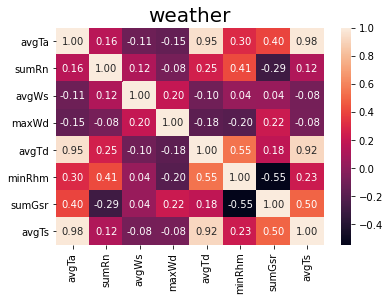

In [15]:
#corr() heatmap
sns.heatmap(weather.corr(), annot=True, fmt='0.2f')
plt.title('weather', fontsize=20)
plt.show()

In [16]:
#sumGsr-avgTs : 0.5
#sumGsr-minRhm : -0.55
#sumGsr-avgTs : 0.4
#sumGsr-avgTs --> accuray = 0.2..
#sumGsr-avgTsm,minRhm --> accuray = 0.6
#sumGsr-avgTsm,minRhm,avgTa --> accuracy = 0.72
#linear regression 
linear,score = preprocessing().reg_score(weather,["avgTs","minRhm","avgTa"],"sumGsr")
score
pred_y = linear.predict(weather.loc[:, ["avgTs","minRhm","avgTa"]])
weather['sumGsr'].fillna(pd.Series(pred_y), inplace=True)

0.7207250314019412

In [17]:
weather.isnull().sum()

tm        0
avgTa     0
sumRn     0
avgWs     0
maxWd     2
avgTd     0
minRhm    0
sumGsr    0
avgTs     0
dtype: int64

In [18]:
#maxWd-sumGsr : 0.2
#Since maxwd does not show significant correlation with other features, 
#maxwd fills it with data from the previous day and the next day.
weather[weather["maxWd"].isnull() == True]

,tm,avgTa,sumRn,avgWs,maxWd,avgTd,minRhm,sumGsr,avgTs
343,2014-02-07,2.4,0.0,4.8,NaN,-8.0,33,9.00,0.6
344,2014-02-08,0.2,4.3,4.3,NaN,-3.0,62,4.73,0.8


In [19]:
weather["maxWd"].fillna(method='ffill', limit=1,inplace=True)

In [20]:
weather[weather["maxWd"].isnull() == True]

,tm,avgTa,sumRn,avgWs,maxWd,avgTd,minRhm,sumGsr,avgTs
344,2014-02-08,0.2,4.3,4.3,NaN,-3.0,62,4.73,0.8


In [21]:
weather["maxWd"].fillna(method='bfill', limit=1,inplace=True)

In [22]:
#cleaned data
weather.isnull().sum()

tm        0
avgTa     0
sumRn     0
avgWs     0
maxWd     0
avgTd     0
minRhm    0
sumGsr    0
avgTs     0
dtype: int64

In [23]:
#beijing data's nan value
beijing.isnull().sum()

PM2.5       8739
PM10        6449
SO2         9021
NO2        12116
CO         20701
O3         13277
TEMP         398
PRES         393
DEWP         403
RAIN         390
wd          1822
WSPM         318
station        0
Date           0
dtype: int64

In [24]:
#Proceed with the same process as Weather.
beijing.corr()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
PM2.5,1.000000,0.884380,0.482354,0.666948,0.789998,-0.149697,-0.131127,0.018566,0.114656,-0.014359,-0.272205
PM10,0.884380,1.000000,0.462651,0.652193,0.702363,-0.111294,-0.096209,-0.017971,0.070310,-0.026519,-0.183665
SO2,0.482354,0.462651,1.000000,0.499496,0.535750,-0.165341,-0.321799,0.223236,-0.266781,-0.040241,-0.108717
NO2,0.666948,0.652193,0.499496,1.000000,0.705500,-0.471587,-0.278192,0.174167,-0.031599,-0.043785,-0.400460
CO,0.789998,0.702363,0.535750,0.705500,1.000000,-0.313012,-0.326237,0.188195,-0.057129,-0.013342,-0.297511
O3,-0.149697,-0.111294,-0.165341,-0.471587,-0.313012,1.000000,0.594910,-0.445961,0.312074,0.023320,0.295743
TEMP,-0.131127,-0.096209,-0.321799,-0.278192,-0.326237,0.594910,1.000000,-0.813309,0.820118,0.037635,0.033036
PRES,0.018566,-0.017971,0.223236,0.174167,0.188195,-0.445961,-0.813309,1.000000,-0.750222,-0.060948,0.065099
DEWP,0.114656,0.070310,-0.266781,-0.031599,-0.057129,0.312074,0.820118,-0.750222,1.000000,0.086292,-0.296591
RAIN,-0.014359,-0.026519,-0.040241,-0.043785,-0.013342,0.023320,0.037635,-0.060948,0.086292,1.000000,0.021022


<AxesSubplot:>

Text(0.5, 1.0, 'Beijing')

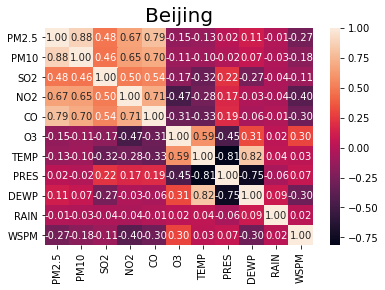

In [25]:
sns.heatmap(beijing.corr(), annot=True, fmt='0.2f')
plt.title('Beijing', fontsize=20)
plt.show()

In [26]:
#onehotencoding for station, wd columns
ohe = OneHotEncoder()
station_oh = ohe.fit_transform(beijing["station"].values.reshape(-1,1)).toarray()
beijing_oh = beijing.copy()
station_oh = pd.DataFrame(station_oh,columns=ohe.categories_[0])

In [27]:
station_oh

,Aotizhongxin,Changping,Dingling,Dongsi,Guanyuan,Gucheng,Huairou,Nongzhanguan,Shunyi,Tiantan,Wanliu,Wanshouxigong
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
420763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
420764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
420765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
420766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [28]:
beijing_oh.drop(columns="station",inplace=True)

In [29]:
beijing_oh = pd.concat([beijing_oh,station_oh],axis=1)

In [30]:
beijing_oh

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,Dingling,Dongsi,Guanyuan,Gucheng,Huairou,Nongzhanguan,Shunyi,Tiantan,Wanliu,Wanshouxigong
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
420764,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
420765,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
420766,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [31]:
#The wind direction is filled with max values.
beijing_oh["wd"].fillna(beijing_oh["wd"].value_counts().index[beijing_oh["wd"].value_counts().argmax()],inplace=True)

In [32]:
beijing_oh["wd"].isnull().sum()

0

In [33]:
#onehotencoding after fill nan values.
wd_oh = ohe.fit_transform(beijing_oh["wd"].values.reshape(-1,1)).toarray()
wd_oh = pd.DataFrame(wd_oh,columns=ohe.categories_[0])
beijing_oh = pd.concat([beijing_oh,wd_oh],axis=1)
beijing_oh.drop(columns="wd",inplace=True)

In [34]:
beijing_oh.columns

Index(['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'WSPM', 'Date', 'Aotizhongxin', 'Changping', 'Dingling',
       'Dongsi', 'Guanyuan', 'Gucheng', 'Huairou', 'Nongzhanguan', 'Shunyi',
       'Tiantan', 'Wanliu', 'Wanshouxigong', 'E', 'ENE', 'ESE', 'N', 'NE',
       'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW'],
      dtype='object')

In [35]:
beijing_oh

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420764,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
420765,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420766,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
beijing_oh.isnull().sum()

PM2.5             8739
PM10              6449
SO2               9021
NO2              12116
CO               20701
O3               13277
TEMP               398
PRES               393
DEWP               403
RAIN               390
WSPM               318
Date                 0
Aotizhongxin         0
Changping            0
Dingling             0
Dongsi               0
Guanyuan             0
Gucheng              0
Huairou              0
Nongzhanguan         0
Shunyi               0
Tiantan              0
Wanliu               0
Wanshouxigong        0
E                    0
ENE                  0
ESE                  0
N                    0
NE                   0
NNE                  0
NNW                  0
NW                   0
S                    0
SE                   0
SSE                  0
SSW                  0
SW                   0
W                    0
WNW                  0
WSW                  0
dtype: int64

In [37]:
#Proceed to fill missing values with the same process as weather data
beijing.corr()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
PM2.5,1.000000,0.884380,0.482354,0.666948,0.789998,-0.149697,-0.131127,0.018566,0.114656,-0.014359,-0.272205
PM10,0.884380,1.000000,0.462651,0.652193,0.702363,-0.111294,-0.096209,-0.017971,0.070310,-0.026519,-0.183665
SO2,0.482354,0.462651,1.000000,0.499496,0.535750,-0.165341,-0.321799,0.223236,-0.266781,-0.040241,-0.108717
NO2,0.666948,0.652193,0.499496,1.000000,0.705500,-0.471587,-0.278192,0.174167,-0.031599,-0.043785,-0.400460
CO,0.789998,0.702363,0.535750,0.705500,1.000000,-0.313012,-0.326237,0.188195,-0.057129,-0.013342,-0.297511
O3,-0.149697,-0.111294,-0.165341,-0.471587,-0.313012,1.000000,0.594910,-0.445961,0.312074,0.023320,0.295743
TEMP,-0.131127,-0.096209,-0.321799,-0.278192,-0.326237,0.594910,1.000000,-0.813309,0.820118,0.037635,0.033036
PRES,0.018566,-0.017971,0.223236,0.174167,0.188195,-0.445961,-0.813309,1.000000,-0.750222,-0.060948,0.065099
DEWP,0.114656,0.070310,-0.266781,-0.031599,-0.057129,0.312074,0.820118,-0.750222,1.000000,0.086292,-0.296591
RAIN,-0.014359,-0.026519,-0.040241,-0.043785,-0.013342,0.023320,0.037635,-0.060948,0.086292,1.000000,0.021022


<AxesSubplot:>

Text(0.5, 1.0, 'Beijing')

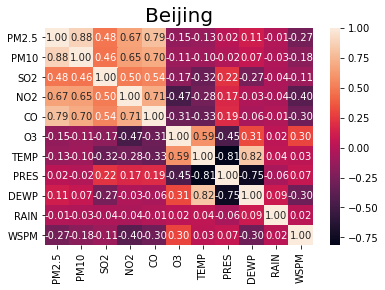

In [38]:
sns.heatmap(beijing.corr(), annot=True, fmt='0.2f')
plt.title('Beijing', fontsize=20)
plt.show()

In [39]:
#predict PM2.5 - using PM10, NO2, CO 
linear,score = preprocessing().reg_score(beijing_oh,["PM10","SO2","NO2","CO"],"PM2.5",0.2,1)
score
pred_y = linear.predict(beijing_oh[["PM10","SO2","NO2","CO"]].dropna(how="any"))
beijing_oh["PM2.5"].fillna(pd.Series(pred_y), inplace=True)

0.8404878754919235

In [40]:
beijing_oh.isnull().sum()

PM2.5              657
PM10              6449
SO2               9021
NO2              12116
CO               20701
O3               13277
TEMP               398
PRES               393
DEWP               403
RAIN               390
WSPM               318
Date                 0
Aotizhongxin         0
Changping            0
Dingling             0
Dongsi               0
Guanyuan             0
Gucheng              0
Huairou              0
Nongzhanguan         0
Shunyi               0
Tiantan              0
Wanliu               0
Wanshouxigong        0
E                    0
ENE                  0
ESE                  0
N                    0
NE                   0
NNE                  0
NNW                  0
NW                   0
S                    0
SE                   0
SSE                  0
SSW                  0
SW                   0
W                    0
WNW                  0
WSW                  0
dtype: int64

In [41]:
#predict PM10 -also using PM2.5,SO2 NO2, CO
#linear regression 
linear,score = preprocessing().reg_score(beijing_oh,["PM2.5","SO2","NO2","CO"],"PM10",0.2,2)
score
pred_y = linear.predict(beijing_oh[["PM2.5","SO2","NO2","CO"]].dropna(how="any"))
beijing_oh["PM10"].fillna(pd.Series(pred_y), inplace=True)
beijing_oh.isnull().sum()

0.7880451901422123

PM2.5              657
PM10               475
SO2               9021
NO2              12116
CO               20701
O3               13277
TEMP               398
PRES               393
DEWP               403
RAIN               390
WSPM               318
Date                 0
Aotizhongxin         0
Changping            0
Dingling             0
Dongsi               0
Guanyuan             0
Gucheng              0
Huairou              0
Nongzhanguan         0
Shunyi               0
Tiantan              0
Wanliu               0
Wanshouxigong        0
E                    0
ENE                  0
ESE                  0
N                    0
NE                   0
NNE                  0
NNW                  0
NW                   0
S                    0
SE                   0
SSE                  0
SSW                  0
SW                   0
W                    0
WNW                  0
WSW                  0
dtype: int64

In [42]:
#predict SO2 -also using PM2.5, PM10, NO2, CO
#linear regression 
linear,score = preprocessing().reg_score(beijing_oh,["PM2.5","PM10","NO2","CO"],"SO2",0.2,3)
score
#Low score, SO2 fills nan values with median instead of regression
beijing_oh["SO2"].fillna(beijing_oh["SO2"].median(), inplace=True)
beijing_oh.isnull().sum() 

0.3233053055211119

PM2.5              657
PM10               475
SO2                  0
NO2              12116
CO               20701
O3               13277
TEMP               398
PRES               393
DEWP               403
RAIN               390
WSPM               318
Date                 0
Aotizhongxin         0
Changping            0
Dingling             0
Dongsi               0
Guanyuan             0
Gucheng              0
Huairou              0
Nongzhanguan         0
Shunyi               0
Tiantan              0
Wanliu               0
Wanshouxigong        0
E                    0
ENE                  0
ESE                  0
N                    0
NE                   0
NNE                  0
NNW                  0
NW                   0
S                    0
SE                   0
SSE                  0
SSW                  0
SW                   0
W                    0
WNW                  0
WSW                  0
dtype: int64

In [43]:
#predict NO2 -also using PM2.5,PM10,SO2,CO
#linear regression 
linear,score = preprocessing().reg_score(beijing_oh,["PM2.5","PM10","SO2","CO"],"NO2",0.2,4)
score
#Low score, NO2 fills nan values with median instead of regression
beijing_oh["NO2"].fillna(beijing_oh["NO2"].median(), inplace=True)
beijing_oh.isnull().sum() 

0.5642223142942144

PM2.5              657
PM10               475
SO2                  0
NO2                  0
CO               20701
O3               13277
TEMP               398
PRES               393
DEWP               403
RAIN               390
WSPM               318
Date                 0
Aotizhongxin         0
Changping            0
Dingling             0
Dongsi               0
Guanyuan             0
Gucheng              0
Huairou              0
Nongzhanguan         0
Shunyi               0
Tiantan              0
Wanliu               0
Wanshouxigong        0
E                    0
ENE                  0
ESE                  0
N                    0
NE                   0
NNE                  0
NNW                  0
NW                   0
S                    0
SE                   0
SSE                  0
SSW                  0
SW                   0
W                    0
WNW                  0
WSW                  0
dtype: int64

In [44]:
#predict CO -also using PM2.5,PM10,SO2,NO2
#linear regression 
linear,score = preprocessing().reg_score(beijing_oh,["PM2.5","PM10","SO2","NO2"],"CO",0.2,5)
score
pred_y = linear.predict(beijing_oh[["PM2.5","PM10","SO2","NO2"]].dropna(how="any"))
beijing_oh["CO"].fillna(pd.Series(pred_y), inplace=True)
beijing_oh.isnull().sum()


0.6940447047646043

PM2.5              657
PM10               475
SO2                  0
NO2                  0
CO                  30
O3               13277
TEMP               398
PRES               393
DEWP               403
RAIN               390
WSPM               318
Date                 0
Aotizhongxin         0
Changping            0
Dingling             0
Dongsi               0
Guanyuan             0
Gucheng              0
Huairou              0
Nongzhanguan         0
Shunyi               0
Tiantan              0
Wanliu               0
Wanshouxigong        0
E                    0
ENE                  0
ESE                  0
N                    0
NE                   0
NNE                  0
NNW                  0
NW                   0
S                    0
SE                   0
SSE                  0
SSW                  0
SW                   0
W                    0
WNW                  0
WSW                  0
dtype: int64

In [46]:
#predict O3 - using NO2,TEMP,PRES
#linear regression 
linear,score = preprocessing().reg_score(beijing_oh,["NO2","TEMP","PRES"],"O3",0.2,6)
score
##Low score, O3 fills nan values with median instead of regression
beijing_oh["O3"].fillna(beijing_oh["O3"].median(), inplace=True)
beijing_oh.isnull().sum() 

0.4440225496587513

PM2.5            657
PM10             475
SO2                0
NO2                0
CO                30
O3                 0
TEMP             398
PRES             393
DEWP             403
RAIN             390
WSPM             318
Date               0
Aotizhongxin       0
Changping          0
Dingling           0
Dongsi             0
Guanyuan           0
Gucheng            0
Huairou            0
Nongzhanguan       0
Shunyi             0
Tiantan            0
Wanliu             0
Wanshouxigong      0
E                  0
ENE                0
ESE                0
N                  0
NE                 0
NNE                0
NNW                0
NW                 0
S                  0
SE                 0
SSE                0
SSW                0
SW                 0
W                  0
WNW                0
WSW                0
dtype: int64

In [47]:
#predict TEMP - using O3,PRES,DEWP
#linear regression 
linear,score = preprocessing().reg_score(beijing_oh,["O3","PRES","DEWP"],"TEMP",0.2,7)
score
pred_y = linear.predict(beijing_oh[["O3","PRES","DEWP"]].dropna(how="any"))
beijing_oh["TEMP"].fillna(pd.Series(pred_y), inplace=True)
beijing_oh.isnull().sum() 

0.8347327253842662

PM2.5            657
PM10             475
SO2                0
NO2                0
CO                30
O3                 0
TEMP               0
PRES             393
DEWP             403
RAIN             390
WSPM             318
Date               0
Aotizhongxin       0
Changping          0
Dingling           0
Dongsi             0
Guanyuan           0
Gucheng            0
Huairou            0
Nongzhanguan       0
Shunyi             0
Tiantan            0
Wanliu             0
Wanshouxigong      0
E                  0
ENE                0
ESE                0
N                  0
NE                 0
NNE                0
NNW                0
NW                 0
S                  0
SE                 0
SSE                0
SSW                0
SW                 0
W                  0
WNW                0
WSW                0
dtype: int64

In [48]:
#predict PRES - using O3,TEMP,DEWP
#linear regression 
linear,score = preprocessing().reg_score(beijing_oh,["O3","TEMP","DEWP"],"PRES",0.2,8)
score
pred_y = linear.predict(beijing_oh[["O3","TEMP","DEWP"]].dropna(how="any"))
beijing_oh["PRES"].fillna(pd.Series(pred_y), inplace=True)
beijing_oh.isnull().sum() 

0.6809102988158559

PM2.5            657
PM10             475
SO2                0
NO2                0
CO                30
O3                 0
TEMP               0
PRES               0
DEWP             403
RAIN             390
WSPM             318
Date               0
Aotizhongxin       0
Changping          0
Dingling           0
Dongsi             0
Guanyuan           0
Gucheng            0
Huairou            0
Nongzhanguan       0
Shunyi             0
Tiantan            0
Wanliu             0
Wanshouxigong      0
E                  0
ENE                0
ESE                0
N                  0
NE                 0
NNE                0
NNW                0
NW                 0
S                  0
SE                 0
SSE                0
SSW                0
SW                 0
W                  0
WNW                0
WSW                0
dtype: int64

In [49]:
#predict DEWP - using TEMP,PRES
#linear regression 
linear,score = preprocessing().reg_score(beijing_oh,["TEMP","PRES"],"DEWP",0.2,9)
score
pred_y = linear.predict(beijing_oh[["TEMP","PRES"]].dropna(how="any"))
beijing_oh["DEWP"].fillna(pd.Series(pred_y), inplace=True)
beijing_oh.isnull().sum() 

0.6932920447888391

PM2.5            657
PM10             475
SO2                0
NO2                0
CO                30
O3                 0
TEMP               0
PRES               0
DEWP               0
RAIN             390
WSPM             318
Date               0
Aotizhongxin       0
Changping          0
Dingling           0
Dongsi             0
Guanyuan           0
Gucheng            0
Huairou            0
Nongzhanguan       0
Shunyi             0
Tiantan            0
Wanliu             0
Wanshouxigong      0
E                  0
ENE                0
ESE                0
N                  0
NE                 0
NNE                0
NNW                0
NW                 0
S                  0
SE                 0
SSE                0
SSW                0
SW                 0
W                  0
WNW                0
WSW                0
dtype: int64

In [50]:
#All columns have low correlation with RAIN
#ffil,limit=1 and bfil,limit=1
beijing_oh[beijing_oh["RAIN"].isnull() == True]
beijing_oh["RAIN"].fillna(method='ffill', limit=1,inplace=True)


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
16748,26.0,42.0,12.0,78.0,1300.0,2.0,-4.961206,1026.330470,-16.390440,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17263,13.0,14.0,12.0,22.0,600.0,60.0,1.926905,1019.586352,-9.058108,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31047,75.0,75.0,4.0,20.0,700.0,209.0,29.114735,999.400722,17.797365,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31315,168.0,168.0,2.0,77.0,1500.0,65.0,21.661374,1004.922422,10.439026,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31316,182.0,182.0,2.0,82.0,1600.0,46.0,21.933462,1005.048650,10.601378,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419791,114.0,143.0,32.0,83.0,2800.0,4.0,4.580722,1020.262806,-7.294768,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
419792,106.0,120.0,27.0,80.0,2400.0,42.0,4.444643,1020.970246,-7.625769,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
419989,46.0,68.0,11.0,13.0,700.0,70.0,-1.513558,1021.173635,-12.143000,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
419990,38.0,82.0,10.0,11.0,600.0,73.0,-1.108295,1019.247020,-11.215662,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
beijing_oh["RAIN"].fillna(method='bfill', limit=1,inplace=True)

In [52]:
beijing_oh[beijing_oh["RAIN"].isnull() == True]

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
31316,182.0,182.0,2.0,82.0,1600.0,46.0,21.933462,1005.048650,10.601378,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31317,137.0,146.0,2.0,44.0,1400.0,122.0,21.274153,1004.946580,10.141906,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31318,107.0,107.0,2.0,34.0,1300.0,108.0,20.257853,1004.879965,9.404237,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31319,95.0,95.0,2.0,38.0,1200.0,78.0,19.260580,1005.325110,8.514880,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34084,112.0,149.0,36.0,97.0,3400.0,54.0,-4.088747,1026.738799,-15.871010,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419788,102.0,118.0,41.0,88.0,3100.0,42.0,5.189531,1017.853348,-6.058835,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
419789,111.0,137.0,40.0,84.0,2800.0,5.0,5.417951,1018.261648,-6.020548,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
419790,124.0,142.0,32.0,84.0,2700.0,4.0,4.768623,1018.408530,-6.553270,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
419791,114.0,143.0,32.0,83.0,2800.0,4.0,4.580722,1020.262806,-7.294768,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
beijing_oh["RAIN"].fillna(beijing_oh["RAIN"].median(),inplace=True)

In [54]:
#All columns have low correlation with WSPM
#ffil,limit=1 and bfil,limit=1
beijing_oh[beijing_oh["WSPM"].isnull() == True]
beijing_oh["WSPM"].fillna(method='ffill', limit=1,inplace=True)
beijing_oh["WSPM"].fillna(method='bfill', limit=1,inplace=True)
beijing_oh[beijing_oh["WSPM"].isnull() == True]


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
16748,26.0,42.0,12.0,78.0,1300.0,2.0,-4.961206,1026.330470,-16.390440,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17263,13.0,14.0,12.0,22.0,600.0,60.0,1.926905,1019.586352,-9.058108,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31315,168.0,168.0,2.0,77.0,1500.0,65.0,21.661374,1004.922422,10.439026,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31316,182.0,182.0,2.0,82.0,1600.0,46.0,21.933462,1005.048650,10.601378,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31317,137.0,146.0,2.0,44.0,1400.0,122.0,21.274153,1004.946580,10.141906,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419789,111.0,137.0,40.0,84.0,2800.0,5.0,5.417951,1018.261648,-6.020548,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
419790,124.0,142.0,32.0,84.0,2700.0,4.0,4.768623,1018.408530,-6.553270,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
419791,114.0,143.0,32.0,83.0,2800.0,4.0,4.580722,1020.262806,-7.294768,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
419989,46.0,68.0,11.0,13.0,700.0,70.0,-1.513558,1021.173635,-12.143000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
31316,182.0,182.0,2.0,82.0,1600.0,46.0,21.933462,1005.048650,10.601378,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31317,137.0,146.0,2.0,44.0,1400.0,122.0,21.274153,1004.946580,10.141906,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31318,107.0,107.0,2.0,34.0,1300.0,108.0,20.257853,1004.879965,9.404237,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34084,112.0,149.0,36.0,97.0,3400.0,54.0,-4.088747,1026.738799,-15.871010,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34085,126.0,135.0,27.0,84.0,2800.0,18.0,-4.652328,1027.077890,-16.401980,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417021,100.0,100.0,3.0,32.0,1300.0,126.0,9.784291,1010.345769,-0.192336,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
417022,89.0,89.0,3.0,28.0,1200.0,108.0,8.983651,1010.372363,-0.799105,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
419788,102.0,118.0,41.0,88.0,3100.0,42.0,5.189531,1017.853348,-6.058835,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
419789,111.0,137.0,40.0,84.0,2800.0,5.0,5.417951,1018.261648,-6.020548,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
beijing_oh["WSPM"].fillna(beijing_oh["WSPM"].median(),inplace=True)

In [56]:
beijing_oh.isnull().sum() 

PM2.5            657
PM10             475
SO2                0
NO2                0
CO                30
O3                 0
TEMP               0
PRES               0
DEWP               0
RAIN               0
WSPM               0
Date               0
Aotizhongxin       0
Changping          0
Dingling           0
Dongsi             0
Guanyuan           0
Gucheng            0
Huairou            0
Nongzhanguan       0
Shunyi             0
Tiantan            0
Wanliu             0
Wanshouxigong      0
E                  0
ENE                0
ESE                0
N                  0
NE                 0
NNE                0
NNW                0
NW                 0
S                  0
SE                 0
SSE                0
SSW                0
SW                 0
W                  0
WNW                0
WSW                0
dtype: int64

In [57]:
#Remaining nan value - PM2.5, PM10,CO 
beijing_oh[beijing_oh["PM2.5"].isnull() == True]
beijing_oh[beijing_oh["PM10"].isnull() == True]
beijing_oh[beijing_oh["CO"].isnull() == True]

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
391720,NaN,32.852898,5.0,12.0,249.390663,42.6258,15.0,1010.9,-13.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
392413,NaN,NaN,9.0,8.0,500.000000,51.0000,10.7,1016.9,-12.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
393371,NaN,156.000000,124.0,88.0,3400.000000,6.0000,0.5,1027.9,-9.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
393375,NaN,90.500000,117.0,116.0,3500.000000,11.0000,1.9,1026.1,-12.7,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
393376,NaN,6.000000,91.0,105.0,2900.000000,14.0000,0.9,1026.4,-13.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420696,NaN,NaN,7.0,43.0,NaN,45.0000,4.2,1020.7,-8.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420709,NaN,NaN,7.0,43.0,NaN,45.0000,12.4,1020.0,-8.2,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420731,NaN,NaN,7.0,43.0,NaN,45.0000,10.0,1018.3,-5.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420732,NaN,NaN,7.0,43.0,NaN,45.0000,12.1,1017.3,-5.4,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
392413,NaN,NaN,9.0,8.0,500.000000,51.0,10.7,1016.9,-12.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
393453,NaN,NaN,7.0,43.0,1327.419089,45.0,-2.9,1025.6,-5.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
393454,NaN,NaN,7.0,43.0,1929.713191,45.0,-4.2,1025.9,-5.9,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
393455,NaN,NaN,7.0,43.0,2264.517713,45.0,-3.6,1025.8,-5.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
393456,NaN,NaN,7.0,43.0,2376.688287,45.0,-4.4,1025.9,-6.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420696,NaN,NaN,7.0,43.0,NaN,45.0,4.2,1020.7,-8.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420709,NaN,NaN,7.0,43.0,NaN,45.0,12.4,1020.0,-8.2,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420731,NaN,NaN,7.0,43.0,NaN,45.0,10.0,1018.3,-5.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420732,NaN,NaN,7.0,43.0,NaN,45.0,12.1,1017.3,-5.4,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
420291,NaN,NaN,7.0,43.0,NaN,45.0,-3.3,1026.3,-20.6,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420422,228.0,228.0,31.0,122.0,NaN,72.0,4.1,1027.7,-3.9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420564,NaN,NaN,7.0,43.0,NaN,45.0,0.7,1029.5,-23.1,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420565,11.0,23.0,7.0,12.0,NaN,61.0,1.9,1028.6,-22.9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420567,NaN,NaN,7.0,43.0,NaN,45.0,3.7,1027.5,-23.2,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420568,NaN,NaN,7.0,43.0,NaN,45.0,4.0,1027.6,-22.9,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420570,NaN,NaN,7.0,43.0,NaN,45.0,3.4,1027.7,-21.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420576,NaN,NaN,7.0,43.0,NaN,45.0,-0.3,1029.9,-20.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
420577,NaN,NaN,7.0,43.0,NaN,45.0,0.0,1029.8,-20.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
420580,NaN,NaN,7.0,43.0,NaN,45.0,-1.2,1029.4,-18.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [58]:
#ffil,limit=1 and bfil,limit=1
beijing_oh[beijing_oh["PM2.5"].isnull() == True]
beijing_oh["PM2.5"].fillna(method='ffill', limit=1,inplace=True)
beijing_oh["PM2.5"].fillna(method='bfill', limit=1,inplace=True)
beijing_oh[beijing_oh["PM2.5"].isnull() == True]


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
391720,NaN,32.852898,5.0,12.0,249.390663,42.6258,15.0,1010.9,-13.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
392413,NaN,NaN,9.0,8.0,500.000000,51.0000,10.7,1016.9,-12.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
393371,NaN,156.000000,124.0,88.0,3400.000000,6.0000,0.5,1027.9,-9.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
393375,NaN,90.500000,117.0,116.0,3500.000000,11.0000,1.9,1026.1,-12.7,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
393376,NaN,6.000000,91.0,105.0,2900.000000,14.0000,0.9,1026.4,-13.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420696,NaN,NaN,7.0,43.0,NaN,45.0000,4.2,1020.7,-8.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420709,NaN,NaN,7.0,43.0,NaN,45.0000,12.4,1020.0,-8.2,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420731,NaN,NaN,7.0,43.0,NaN,45.0000,10.0,1018.3,-5.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420732,NaN,NaN,7.0,43.0,NaN,45.0000,12.1,1017.3,-5.4,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
393376,NaN,6.0,91.0,105.0,2900.000000,14.0,0.900,1026.40,-13.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
393454,NaN,NaN,7.0,43.0,1929.713191,45.0,-4.200,1025.90,-5.9,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
393455,NaN,NaN,7.0,43.0,2264.517713,45.0,-3.600,1025.80,-5.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
393456,NaN,NaN,7.0,43.0,2376.688287,45.0,-4.400,1025.90,-6.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
393457,NaN,NaN,7.0,43.0,2488.654567,45.0,-6.000,1026.30,-7.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416971,NaN,100.0,3.0,53.0,1400.000000,146.0,24.450,1006.00,17.1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
416972,NaN,121.0,4.0,61.0,1700.000000,109.0,23.650,1006.75,16.7,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
416973,NaN,133.0,4.0,76.0,2000.000000,91.0,22.775,1007.00,16.5,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
417470,NaN,NaN,11.0,149.0,2200.000000,61.0,21.500,1015.80,14.6,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [59]:
beijing_oh["PM2.5"].fillna(beijing_oh["PM2.5"].median(),inplace=True)

In [60]:
#ffil,limit=1 and bfil,limit=1
beijing_oh[beijing_oh["PM10"].isnull() == True]
beijing_oh["PM10"].fillna(method='ffill', limit=1,inplace=True)
beijing_oh["PM10"].fillna(method='bfill', limit=1,inplace=True)
beijing_oh[beijing_oh["PM10"].isnull() == True]

beijing_oh["PM10"].fillna(beijing_oh["PM10"].median(),inplace=True)

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
392413,7.0,NaN,9.0,8.0,500.000000,51.0,10.7,1016.9,-12.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
393453,396.0,NaN,7.0,43.0,1327.419089,45.0,-2.9,1025.6,-5.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
393454,55.0,NaN,7.0,43.0,1929.713191,45.0,-4.2,1025.9,-5.9,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
393455,55.0,NaN,7.0,43.0,2264.517713,45.0,-3.6,1025.8,-5.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
393456,55.0,NaN,7.0,43.0,2376.688287,45.0,-4.4,1025.9,-6.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420696,14.0,NaN,7.0,43.0,NaN,45.0,4.2,1020.7,-8.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420709,21.0,NaN,7.0,43.0,NaN,45.0,12.4,1020.0,-8.2,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420731,103.0,NaN,7.0,43.0,NaN,45.0,10.0,1018.3,-5.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420732,55.0,NaN,7.0,43.0,NaN,45.0,12.1,1017.3,-5.4,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
393454,55.0,NaN,7.0,43.0,1929.713191,45.0,-4.2,1025.9,-5.9,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
393455,55.0,NaN,7.0,43.0,2264.517713,45.0,-3.6,1025.8,-5.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
393456,55.0,NaN,7.0,43.0,2376.688287,45.0,-4.4,1025.9,-6.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
393457,55.0,NaN,7.0,43.0,2488.654567,45.0,-6.0,1026.3,-7.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
393458,55.0,NaN,7.0,43.0,2714.193826,45.0,-6.4,1026.6,-7.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416573,55.0,NaN,7.0,43.0,1809.934886,45.0,22.8,1002.1,15.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
416574,55.0,NaN,7.0,43.0,1674.901006,45.0,22.5,1002.5,15.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
416575,55.0,NaN,7.0,43.0,1569.982389,45.0,21.9,1003.0,16.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
417470,55.0,NaN,11.0,149.0,2200.000000,61.0,21.5,1015.8,14.6,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [61]:
#ffil,limit=1 and bfil,limit=1
beijing_oh[beijing_oh["CO"].isnull() == True]
beijing_oh["CO"].fillna(method='ffill', limit=1,inplace=True)
beijing_oh["CO"].fillna(method='bfill', limit=1,inplace=True)
beijing_oh[beijing_oh["CO"].isnull() == True]

beijing_oh["CO"].fillna(beijing_oh["CO"].median(),inplace=True)

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
420291,8.0,10.0,7.0,43.0,NaN,45.0,-3.3,1026.3,-20.6,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420422,228.0,228.0,31.0,122.0,NaN,72.0,4.1,1027.7,-3.9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420564,15.0,23.0,7.0,43.0,NaN,45.0,0.7,1029.5,-23.1,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420565,11.0,23.0,7.0,12.0,NaN,61.0,1.9,1028.6,-22.9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420567,14.0,21.0,7.0,43.0,NaN,45.0,3.7,1027.5,-23.2,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420568,12.0,23.0,7.0,43.0,NaN,45.0,4.0,1027.6,-22.9,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420570,12.0,23.0,7.0,43.0,NaN,45.0,3.4,1027.7,-21.7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420576,41.0,58.0,7.0,43.0,NaN,45.0,-0.3,1029.9,-20.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
420577,61.0,73.0,7.0,43.0,NaN,45.0,0.0,1029.8,-20.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
420580,62.0,85.0,7.0,43.0,NaN,45.0,-1.2,1029.4,-18.3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
420732,55.0,82.0,7.0,43.0,NaN,45.0,12.1,1017.3,-5.4,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [62]:
#cleaned data
beijing_oh.isnull().sum()

PM2.5            0
PM10             0
SO2              0
NO2              0
CO               0
O3               0
TEMP             0
PRES             0
DEWP             0
RAIN             0
WSPM             0
Date             0
Aotizhongxin     0
Changping        0
Dingling         0
Dongsi           0
Guanyuan         0
Gucheng          0
Huairou          0
Nongzhanguan     0
Shunyi           0
Tiantan          0
Wanliu           0
Wanshouxigong    0
E                0
ENE              0
ESE              0
N                0
NE               0
NNE              0
NNW              0
NW               0
S                0
SE               0
SSE              0
SSW              0
SW               0
W                0
WNW              0
WSW              0
dtype: int64

In [63]:
clean_beijing = beijing_oh.copy()

In [64]:
clean_beijing.columns

Index(['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP',
       'RAIN', 'WSPM', 'Date', 'Aotizhongxin', 'Changping', 'Dingling',
       'Dongsi', 'Guanyuan', 'Gucheng', 'Huairou', 'Nongzhanguan', 'Shunyi',
       'Tiantan', 'Wanliu', 'Wanshouxigong', 'E', 'ENE', 'ESE', 'N', 'NE',
       'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE', 'SSW', 'SW', 'W', 'WNW', 'WSW'],
      dtype='object')

In [65]:
#scaling dataset with standard, minmax, maxabs,robust scalier
std_beijing = pd.DataFrame(StandardScaler().fit_transform(clean_beijing.iloc[:,:11]),columns=clean_beijing.iloc[:,:11].columns)
mm_beijing = pd.DataFrame(MinMaxScaler().fit_transform(clean_beijing.iloc[:,:11]),columns=clean_beijing.iloc[:,:11].columns)
ma_beijing = pd.DataFrame(MaxAbsScaler().fit_transform(clean_beijing.iloc[:,:11]),columns=clean_beijing.iloc[:,:11].columns)
rb_beijing = pd.DataFrame(RobustScaler().fit_transform(clean_beijing.iloc[:,:11]),columns=clean_beijing.iloc[:,:11].columns)

In [66]:
std_beijing = pd.concat([std_beijing,clean_beijing.iloc[:,11:]],axis=1,ignore_index = True)
mm_beijing = pd.concat([mm_beijing,clean_beijing.iloc[:,11:]],axis=1,ignore_index = True)
ma_beijing = pd.concat([ma_beijing,clean_beijing.iloc[:,11:]],axis=1,ignore_index = True)
rb_beijing = pd.concat([rb_beijing,clean_beijing.iloc[:,11:]],axis=1,ignore_index = True)
std_beijing.columns=clean_beijing.columns
mm_beijing.columns=clean_beijing.columns
ma_beijing.columns=clean_beijing.columns
rb_beijing.columns=clean_beijing.columns


In [67]:
clean_beijing
std_beijing
mm_beijing
ma_beijing
rb_beijing

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420764,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
420765,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420766,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,-0.939245,-1.097177,-0.542591,-1.253353,-0.809354,0.358733,-1.244496,1.169246,-1.543186,-0.078511,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.889650,-1.053569,-0.542591,-1.253353,-0.809354,0.358733,-1.279475,1.188342,-1.499681,-0.078511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.902048,-1.064471,-0.495983,-1.166753,-0.809354,0.287051,-1.279475,1.216985,-1.499681,-0.078511,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.914447,-1.075373,-0.216333,-1.137886,-0.809354,0.269131,-1.305709,1.312463,-1.586690,-0.078511,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.951644,-1.108079,-0.169725,-1.109019,-0.809354,0.269131,-1.358177,1.379297,-1.593941,-0.078511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,-0.852453,-0.791921,-0.589200,-0.762619,-0.722369,0.269131,-0.090195,0.262206,-1.354665,-0.078511,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420764,-0.827655,-0.791921,-0.589200,-0.271885,-0.635384,-0.125118,-0.168898,0.271754,-1.274906,-0.078511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
420765,-0.815257,-0.835529,-0.542591,-0.358485,-0.635384,-0.053436,-0.238855,0.329041,-1.144391,-0.078511,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420766,-0.840054,-0.890039,-0.542591,-0.589419,-0.722369,0.036166,-0.265089,0.348137,-1.115388,-0.078511,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,0.008859,0.002006,0.007433,0.020671,0.033903,0.071710,0.312195,0.672185,0.339310,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.012843,0.006018,0.007433,0.020671,0.033903,0.071710,0.305691,0.675497,0.347586,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.011847,0.005015,0.009434,0.031053,0.033903,0.067974,0.305691,0.680464,0.347586,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.010851,0.004012,0.021441,0.034514,0.033903,0.067040,0.300813,0.697020,0.331034,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.007862,0.001003,0.023442,0.037974,0.033903,0.067040,0.291057,0.708609,0.329655,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,0.015831,0.030090,0.005432,0.079500,0.043863,0.067040,0.526829,0.514901,0.375172,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420764,0.017824,0.030090,0.005432,0.138329,0.053822,0.046495,0.512195,0.516556,0.390345,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
420765,0.018820,0.026078,0.007433,0.127948,0.053822,0.050230,0.499187,0.526490,0.415172,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420766,0.016828,0.021063,0.007433,0.100264,0.043863,0.054900,0.494309,0.529801,0.420690,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,0.004004,0.004004,0.008,0.024138,0.03,0.071895,-0.016827,0.981013,-0.433180,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.008008,0.008008,0.008,0.024138,0.03,0.071895,-0.026442,0.981204,-0.419355,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.007007,0.007007,0.010,0.034483,0.03,0.068161,-0.026442,0.981492,-0.419355,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.006006,0.006006,0.022,0.037931,0.03,0.067227,-0.033654,0.982451,-0.447005,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.003003,0.003003,0.024,0.041379,0.03,0.067227,-0.048077,0.983122,-0.449309,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,0.011011,0.032032,0.006,0.082759,0.04,0.067227,0.300481,0.971903,-0.373272,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420764,0.013013,0.032032,0.006,0.141379,0.05,0.046685,0.278846,0.971998,-0.347926,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
420765,0.014014,0.028028,0.008,0.131034,0.05,0.050420,0.259615,0.972574,-0.306452,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420766,0.012012,0.023023,0.008,0.103448,0.04,0.055089,0.252404,0.972766,-0.297235,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,-0.560440,-0.715596,-0.1875,-0.782609,-0.6,0.470588,-0.756219,0.754491,-0.908333,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.516484,-0.678899,-0.1875,-0.782609,-0.6,0.470588,-0.776119,0.766467,-0.883333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.527473,-0.688073,-0.1250,-0.717391,-0.6,0.411765,-0.776119,0.784431,-0.883333,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.538462,-0.697248,0.2500,-0.695652,-0.6,0.397059,-0.791045,0.844311,-0.933333,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.571429,-0.724771,0.3125,-0.673913,-0.6,0.397059,-0.820896,0.886228,-0.937500,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,-0.483516,-0.458716,-0.2500,-0.413043,-0.5,0.397059,-0.099502,0.185629,-0.800000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420764,-0.461538,-0.458716,-0.2500,-0.043478,-0.4,0.073529,-0.144279,0.191617,-0.754167,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
420765,-0.450549,-0.495413,-0.1875,-0.108696,-0.4,0.132353,-0.184080,0.227545,-0.679167,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420766,-0.472527,-0.541284,-0.1875,-0.282609,-0.5,0.205882,-0.199005,0.239521,-0.662500,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
std_weather = pd.DataFrame(StandardScaler().fit_transform(weather.drop(columns="tm")),columns=weather.drop(columns="tm").columns)
std_weather["tm"]=weather["tm"]

In [69]:
mm_weather = pd.DataFrame(MinMaxScaler().fit_transform(weather.drop(columns="tm")),columns=weather.drop(columns="tm").columns)
mm_weather["tm"]=weather["tm"]

In [70]:
ma_weather = pd.DataFrame(MaxAbsScaler().fit_transform(weather.drop(columns="tm")),columns=weather.drop(columns="tm").columns)
ma_weather["tm"]=weather["tm"]

In [71]:
rb_weather = pd.DataFrame(RobustScaler().fit_transform(weather.drop(columns="tm")),columns=weather.drop(columns="tm").columns)
rb_weather["tm"]=weather["tm"]

In [72]:
std_weather
mm_weather
ma_weather
rb_weather

,avgTa,sumRn,avgWs,maxWd,avgTd,minRhm,sumGsr,avgTs,tm
0,-1.185810,0.031480,2.613493,0.777631,-1.049269,-0.221881,0.491986,-1.027178,2013-03-01
1,-1.337014,-0.270641,0.734980,0.777631,-1.465070,-0.602064,0.390527,-1.150565,2013-03-02
2,-1.223611,-0.270641,0.382758,0.777631,-1.227469,-0.792155,0.688251,-1.044805,2013-03-03
3,-0.968454,-0.270641,0.265351,0.967395,-0.820154,-0.918882,-0.283096,-1.018364,2013-03-04
4,-0.911753,-0.270641,0.500166,0.398102,-0.930468,-0.982246,0.598435,-0.877350,2013-03-05
...,...,...,...,...,...,...,...,...,...
1456,-1.337014,-0.270641,-0.439091,0.777631,-1.303841,-1.045609,0.325659,-1.203445,2017-02-24
1457,-1.015706,-0.270641,-0.321684,0.113456,-0.794697,-0.411972,0.463710,-1.053618,2017-02-25
1458,-0.921203,-0.270641,-0.556498,0.777631,-0.981383,-1.235700,0.440425,-0.983111,2017-02-26
1459,-0.911753,-0.270641,-0.908720,0.777631,-1.286869,-1.299064,0.593445,-0.965484,2017-02-27


,avgTa,sumRn,avgWs,maxWd,avgTd,minRhm,sumGsr,avgTs,tm
0,0.331878,0.018182,0.698113,0.735294,0.342742,0.313953,0.525400,0.242038,2013-03-01
1,0.296943,0.000000,0.396226,0.735294,0.243952,0.244186,0.503730,0.212314,2013-03-02
2,0.323144,0.000000,0.339623,0.735294,0.300403,0.209302,0.567318,0.237792,2013-03-03
3,0.382096,0.000000,0.320755,0.794118,0.397177,0.186047,0.359858,0.244161,2013-03-04
4,0.395197,0.000000,0.358491,0.617647,0.370968,0.174419,0.548135,0.278132,2013-03-05
...,...,...,...,...,...,...,...,...,...
1456,0.296943,0.000000,0.207547,0.735294,0.282258,0.162791,0.489876,0.199575,2017-02-24
1457,0.371179,0.000000,0.226415,0.529412,0.403226,0.279070,0.519361,0.235669,2017-02-25
1458,0.393013,0.000000,0.188679,0.735294,0.358871,0.127907,0.514387,0.252654,2017-02-26
1459,0.395197,0.000000,0.132075,0.735294,0.286290,0.116279,0.547069,0.256900,2017-02-27


,avgTa,sumRn,avgWs,maxWd,avgTd,minRhm,sumGsr,avgTs,tm
0,0.025478,0.018182,0.750000,0.750000,-0.288538,0.372340,0.533520,0.089286,2013-03-01
1,-0.025478,0.000000,0.500000,0.750000,-0.482213,0.308511,0.512221,0.053571,2013-03-02
2,0.012739,0.000000,0.453125,0.750000,-0.371542,0.276596,0.574721,0.084184,2013-03-03
3,0.098726,0.000000,0.437500,0.805556,-0.181818,0.255319,0.370810,0.091837,2013-03-04
4,0.117834,0.000000,0.468750,0.638889,-0.233202,0.244681,0.555866,0.132653,2013-03-05
...,...,...,...,...,...,...,...,...,...
1456,-0.025478,0.000000,0.343750,0.750000,-0.407115,0.234043,0.498603,0.038265,2017-02-24
1457,0.082803,0.000000,0.359375,0.555556,-0.169960,0.340426,0.527584,0.081633,2017-02-25
1458,0.114650,0.000000,0.328125,0.750000,-0.256917,0.202128,0.522696,0.102041,2017-02-26
1459,0.117834,0.000000,0.281250,0.750000,-0.399209,0.191489,0.554818,0.107143,2017-02-27


,avgTa,sumRn,avgWs,maxWd,avgTd,minRhm,sumGsr,avgTs,tm
0,-0.709845,7.5,2.4,0.10,-0.656863,-0.047619,0.391106,-0.591743,2013-03-01
1,-0.792746,0.0,0.8,0.10,-0.897059,-0.333333,0.321551,-0.655963,2013-03-02
2,-0.730570,0.0,0.5,0.10,-0.759804,-0.476190,0.525656,-0.600917,2013-03-03
3,-0.590674,0.0,0.4,0.20,-0.524510,-0.571429,-0.140251,-0.587156,2013-03-04
4,-0.559585,0.0,0.6,-0.10,-0.588235,-0.619048,0.464082,-0.513761,2013-03-05
...,...,...,...,...,...,...,...,...,...
1456,-0.792746,0.0,-0.2,0.10,-0.803922,-0.666667,0.277081,-0.683486,2017-02-24
1457,-0.616580,0.0,-0.1,-0.25,-0.509804,-0.190476,0.371722,-0.605505,2017-02-25
1458,-0.564767,0.0,-0.3,0.10,-0.617647,-0.809524,0.355758,-0.568807,2017-02-26
1459,-0.559585,0.0,-0.6,0.10,-0.794118,-0.857143,0.460661,-0.559633,2017-02-27


In [120]:
#seoul data onehotencoding for MSRSTE_NM
ohe = OneHotEncoder()
Nm_oh = ohe.fit_transform(seoul["MSRSTE_NM"].values.reshape(-1,1)).toarray()
seoul_oh = seoul.copy()
Nm_oh = pd.DataFrame(Nm_oh,columns=ohe.categories_[0])
Nm_oh
seoul_oh.drop(columns="MSRSTE_NM",inplace=True)
seoul_oh = pd.concat([seoul_oh,Nm_oh],axis=1)


,강남구,강동구,강북구,강서구,관악구,광진구,구로구,금천구,노원구,도봉구,...,성동구,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
872897,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
872898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
872899,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
seoul_oh["영등포구"]

0         1.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
872896    0.0
872897    0.0
872898    0.0
872899    0.0
872900    0.0
Name: 영등포구, Length: 872901, dtype: float64

In [75]:
seoul_oh

,MSRDT,NO2,O3,CO,SO2,PM10,PM25,강남구,강동구,강북구,...,성동구,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구
0,2013-03-01 23:00:00,0.021,0.030,0.7,0.005,45.0,20.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2013-03-01 23:00:00,0.014,0.034,0.3,0.004,38.0,15.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-03-01 23:00:00,0.016,0.033,0.4,0.006,38.0,18.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-03-01 23:00:00,0.021,0.027,0.4,0.005,43.0,21.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-03-01 23:00:00,0.018,0.035,0.3,0.006,43.0,17.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872896,2017-02-28 00:00:00,0.063,0.002,0.7,0.004,29.0,18.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
872897,2017-02-28 00:00:00,0.064,0.002,0.7,0.005,37.0,23.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
872898,2017-02-28 00:00:00,0.060,0.003,0.4,0.004,22.0,14.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
872899,2017-02-28 00:00:00,0.053,0.006,0.4,0.006,34.0,21.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
std_seoul = pd.DataFrame(StandardScaler().fit_transform(seoul_oh.iloc[:,1:7]),columns=seoul_oh.iloc[:,1:7].columns)
mm_seoul = pd.DataFrame(MinMaxScaler().fit_transform(seoul_oh.iloc[:,1:7]),columns=seoul_oh.iloc[:,1:7].columns)
ma_seoul = pd.DataFrame(MaxAbsScaler().fit_transform(seoul_oh.iloc[:,1:7]),columns=seoul_oh.iloc[:,1:7].columns)
rb_seoul = pd.DataFrame(RobustScaler().fit_transform(seoul_oh.iloc[:,1:7]),columns=seoul_oh.iloc[:,1:7].columns)

In [77]:
col = seoul_oh.iloc[:,1:7].columns.append(seoul_oh.drop(columns=std_seoul.columns).columns)

In [107]:
std_seoul = pd.concat([std_seoul,seoul_oh.drop(columns=std_seoul.columns)],axis=1,ignore_index = True)
mm_seoul = pd.concat([mm_seoul,seoul_oh.drop(columns=mm_seoul.columns)],axis=1,ignore_index = True)
ma_seoul = pd.concat([ma_seoul,seoul_oh.drop(columns=ma_seoul.columns)],axis=1,ignore_index = True)
rb_seoul = pd.concat([rb_seoul,seoul_oh.drop(columns=rb_seoul.columns)],axis=1,ignore_index = True)
std_seoul.columns=col
mm_seoul.columns=col
ma_seoul.columns=col
rb_seoul.columns=col

In [108]:
std_seoul
mm_seoul
ma_seoul
rb_seoul

,NO2,O3,CO,SO2,PM10,PM25,MSRDT,강남구,강동구,강북구,...,성동구,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구
0,-0.609132,0.401441,0.705679,-0.075234,0.007840,-0.140831,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.011489,0.613121,-0.771591,-0.506737,-0.193438,-0.320985,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.896530,0.560201,-0.402274,0.356270,-0.193438,-0.212893,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.609132,0.242681,-0.402274,-0.075234,-0.049668,-0.104800,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.781571,0.666041,-0.771591,0.356270,-0.049668,-0.248923,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872896,1.805011,-1.080317,0.705679,-0.506737,-0.452224,-0.212893,2017-02-28 00:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
872897,1.862490,-1.080317,0.705679,-0.075234,-0.222192,-0.032739,2017-02-28 00:00:00,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
872898,1.632572,-1.027397,-0.402274,-0.506737,-0.653502,-0.357015,2017-02-28 00:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
872899,1.230215,-0.868637,-0.402274,0.356270,-0.308454,-0.104800,2017-02-28 00:00:00,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,NO2,O3,CO,SO2,PM10,PM25,MSRDT,강남구,강동구,강북구,...,성동구,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구
0,0.103774,0.175439,0.142857,0.065789,0.038793,0.014210,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.070755,0.198830,0.061224,0.052632,0.032759,0.013714,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.080189,0.192982,0.081633,0.078947,0.032759,0.014012,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.103774,0.157895,0.081633,0.065789,0.037069,0.014310,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.089623,0.204678,0.061224,0.078947,0.037069,0.013912,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872896,0.301887,0.011696,0.142857,0.052632,0.025000,0.014012,2017-02-28 00:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
872897,0.306604,0.011696,0.142857,0.065789,0.031897,0.014509,2017-02-28 00:00:00,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
872898,0.287736,0.017544,0.081633,0.052632,0.018966,0.013614,2017-02-28 00:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
872899,0.254717,0.035088,0.081633,0.078947,0.029310,0.014310,2017-02-28 00:00:00,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,NO2,O3,CO,SO2,PM10,PM25,MSRDT,강남구,강동구,강북구,...,성동구,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구
0,0.099526,0.175439,0.142857,0.065789,0.038793,0.002012,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.066351,0.198830,0.061224,0.052632,0.032759,0.001509,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.075829,0.192982,0.081633,0.078947,0.032759,0.001811,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.099526,0.157895,0.081633,0.065789,0.037069,0.002113,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.085308,0.204678,0.061224,0.078947,0.037069,0.001710,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872896,0.298578,0.011696,0.142857,0.052632,0.025000,0.001811,2017-02-28 00:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
872897,0.303318,0.011696,0.142857,0.065789,0.031897,0.002314,2017-02-28 00:00:00,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
872898,0.284360,0.017544,0.081633,0.052632,0.018966,0.001408,2017-02-28 00:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
872899,0.251185,0.035088,0.081633,0.078947,0.029310,0.002113,2017-02-28 00:00:00,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,NO2,O3,CO,SO2,PM10,PM25,MSRDT,강남구,강동구,강북구,...,성동구,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구
0,-0.333333,0.423077,0.666667,0.0,0.21875,-0.055556,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.625000,0.576923,-0.666667,-0.5,0.00000,-0.333333,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.541667,0.538462,-0.333333,0.5,0.00000,-0.166667,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.333333,0.307692,-0.333333,0.0,0.15625,0.000000,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.458333,0.615385,-0.666667,0.5,0.15625,-0.222222,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872896,1.416667,-0.653846,0.666667,-0.5,-0.28125,-0.166667,2017-02-28 00:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
872897,1.458333,-0.653846,0.666667,0.0,-0.03125,0.111111,2017-02-28 00:00:00,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
872898,1.291667,-0.615385,-0.333333,-0.5,-0.50000,-0.388889,2017-02-28 00:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
872899,1.000000,-0.500000,-0.333333,0.5,-0.12500,0.000000,2017-02-28 00:00:00,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
#**************data analysis*********************#
#Create decision Tree,Analysis of features that have the greatest importance in predicting fine dust.

In [122]:
std_weather
std_seoul
std_beijing

,avgTa,sumRn,avgWs,maxWd,avgTd,minRhm,sumGsr,avgTs,tm
0,-1.185810,0.031480,2.613493,0.777631,-1.049269,-0.221881,0.491986,-1.027178,2013-03-01
1,-1.337014,-0.270641,0.734980,0.777631,-1.465070,-0.602064,0.390527,-1.150565,2013-03-02
2,-1.223611,-0.270641,0.382758,0.777631,-1.227469,-0.792155,0.688251,-1.044805,2013-03-03
3,-0.968454,-0.270641,0.265351,0.967395,-0.820154,-0.918882,-0.283096,-1.018364,2013-03-04
4,-0.911753,-0.270641,0.500166,0.398102,-0.930468,-0.982246,0.598435,-0.877350,2013-03-05
...,...,...,...,...,...,...,...,...,...
1456,-1.337014,-0.270641,-0.439091,0.777631,-1.303841,-1.045609,0.325659,-1.203445,2017-02-24
1457,-1.015706,-0.270641,-0.321684,0.113456,-0.794697,-0.411972,0.463710,-1.053618,2017-02-25
1458,-0.921203,-0.270641,-0.556498,0.777631,-0.981383,-1.235700,0.440425,-0.983111,2017-02-26
1459,-0.911753,-0.270641,-0.908720,0.777631,-1.286869,-1.299064,0.593445,-0.965484,2017-02-27


,NO2,O3,CO,SO2,PM10,PM25,MSRDT,강남구,강동구,강북구,...,성동구,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구
0,-0.609132,0.401441,0.705679,-0.075234,0.007840,-0.140831,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.011489,0.613121,-0.771591,-0.506737,-0.193438,-0.320985,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.896530,0.560201,-0.402274,0.356270,-0.193438,-0.212893,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.609132,0.242681,-0.402274,-0.075234,-0.049668,-0.104800,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.781571,0.666041,-0.771591,0.356270,-0.049668,-0.248923,2013-03-01 23:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872896,1.805011,-1.080317,0.705679,-0.506737,-0.452224,-0.212893,2017-02-28 00:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
872897,1.862490,-1.080317,0.705679,-0.075234,-0.222192,-0.032739,2017-02-28 00:00:00,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
872898,1.632572,-1.027397,-0.402274,-0.506737,-0.653502,-0.357015,2017-02-28 00:00:00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
872899,1.230215,-0.868637,-0.402274,0.356270,-0.308454,-0.104800,2017-02-28 00:00:00,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,-0.939245,-1.097177,-0.542591,-1.253353,-0.809354,0.358733,-1.244496,1.169246,-1.543186,-0.078511,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.889650,-1.053569,-0.542591,-1.253353,-0.809354,0.358733,-1.279475,1.188342,-1.499681,-0.078511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.902048,-1.064471,-0.495983,-1.166753,-0.809354,0.287051,-1.279475,1.216985,-1.499681,-0.078511,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.914447,-1.075373,-0.216333,-1.137886,-0.809354,0.269131,-1.305709,1.312463,-1.586690,-0.078511,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.951644,-1.108079,-0.169725,-1.109019,-0.809354,0.269131,-1.358177,1.379297,-1.593941,-0.078511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,-0.852453,-0.791921,-0.589200,-0.762619,-0.722369,0.269131,-0.090195,0.262206,-1.354665,-0.078511,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420764,-0.827655,-0.791921,-0.589200,-0.271885,-0.635384,-0.125118,-0.168898,0.271754,-1.274906,-0.078511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
420765,-0.815257,-0.835529,-0.542591,-0.358485,-0.635384,-0.053436,-0.238855,0.329041,-1.144391,-0.078511,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
420766,-0.840054,-0.890039,-0.542591,-0.589419,-0.722369,0.036166,-0.265089,0.348137,-1.115388,-0.078511,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
#Seoul data -> group by date, reduced to 1461 lines as shown by weather data.
#Beijing Data -> the same process.
std_seoul_group = std_seoul.groupby(std_seoul['MSRDT'].dt.date).mean()
std_seoul_group = std_seoul_group.iloc[:,:6]


In [149]:
std_seoul_group

,NO2,O3,CO,SO2,PM10,PM25
MSRDT,,,,,,
2013-03-01,-0.853229,0.691971,-0.473675,-0.156500,0.230731,-0.168875
2013-03-02,-0.719014,0.545736,-0.537075,-0.294581,-0.295659,-0.202384
2013-03-03,-0.358330,0.192143,-0.188070,0.140518,-0.202256,-0.224843
2013-03-04,0.583665,-0.249739,0.628738,1.478181,0.662664,0.343662
2013-03-05,0.762331,-0.061167,1.122392,1.944924,1.154645,0.740960
...,...,...,...,...,...,...
2017-02-24,-0.250364,0.071397,-0.236081,-0.149308,-0.503359,-0.261534
2017-02-25,0.363135,-0.205727,0.624429,0.141957,0.032041,0.194314
2017-02-26,-0.116436,0.012392,0.482242,-0.125576,0.069038,0.274062


In [125]:
std_beijing_group = std_beijing.iloc[:,:12].groupby(std_beijing['Date'].dt.date).mean()
#Maximum wind direction (number of times) is obtained for wind direction data analysis.
std_beijing_wd = std_beijing.iloc[:,24:].groupby(std_beijing['Date'].dt.date).sum().idxmax(axis=1)
std_beijing_wd = pd.DataFrame(std_beijing_wd,columns = ["WD"])

In [126]:
std_beijing_group = pd.concat([std_beijing_group,std_beijing_wd,],axis=1)

In [127]:
#wind direction onehotencoding 
ohe = OneHotEncoder()
group_wd_oh = ohe.fit_transform(std_beijing_group["WD"].values.reshape(-1,1)).toarray()
group_wd_oh = pd.DataFrame(group_wd_oh,index =std_beijing_group.index , columns=ohe.categories_[0])
std_beijing_group = pd.concat([std_beijing_group,group_wd_oh],axis = 1)

In [116]:
std_beijing_group.drop(columns="WD",inplace = True)


In [128]:
std_beijing_group

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
Date,,,,,,,,,,,,,,,,,,,,,
2013-03-01,-0.898002,-1.003548,-0.298707,-0.742272,-0.718773,0.197387,-1.080624,1.510082,-1.640971,-0.078511,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-03-02,-0.598578,-0.698124,0.746626,0.174595,-0.251465,-0.436539,-1.160510,1.508458,-1.359876,-0.078511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-03-03,-0.005715,0.070474,1.565950,0.740655,0.470672,-0.612764,-0.723549,0.330500,-1.073721,-0.078511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-03-04,-0.688947,-0.695641,0.145575,-0.210531,-0.438861,-0.002662,-0.342850,0.621508,-1.106199,-0.078511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-03-05,0.709812,0.595209,2.533235,1.437465,0.712305,0.404031,-0.603461,-0.019321,-0.754031,-0.078511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-24,-0.675271,-0.717782,-0.285436,-0.168847,-0.447173,-0.197733,-0.756827,0.820686,-1.003126,-0.078511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-02-25,-0.847521,-0.903899,-0.467338,-0.571477,-0.663848,0.032183,-0.567632,0.611695,-0.947612,-0.078511,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-02-26,-0.645560,-0.651780,-0.263427,-0.000959,-0.459764,-0.261761,-0.591346,0.754813,-0.760501,-0.078511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
std_weather.index = std_weather["tm"]
std_weather.drop(columns="tm",inplace= True)

In [137]:
std_weather

,avgTa,sumRn,avgWs,maxWd,avgTd,minRhm,sumGsr,avgTs
tm,,,,,,,,
2013-03-01,-1.185810,0.031480,2.613493,0.777631,-1.049269,-0.221881,0.491986,-1.027178
2013-03-02,-1.337014,-0.270641,0.734980,0.777631,-1.465070,-0.602064,0.390527,-1.150565
2013-03-03,-1.223611,-0.270641,0.382758,0.777631,-1.227469,-0.792155,0.688251,-1.044805
2013-03-04,-0.968454,-0.270641,0.265351,0.967395,-0.820154,-0.918882,-0.283096,-1.018364
2013-03-05,-0.911753,-0.270641,0.500166,0.398102,-0.930468,-0.982246,0.598435,-0.877350
...,...,...,...,...,...,...,...,...
2017-02-24,-1.337014,-0.270641,-0.439091,0.777631,-1.303841,-1.045609,0.325659,-1.203445
2017-02-25,-1.015706,-0.270641,-0.321684,0.113456,-0.794697,-0.411972,0.463710,-1.053618
2017-02-26,-0.921203,-0.270641,-0.556498,0.777631,-0.981383,-1.235700,0.440425,-0.983111


In [150]:
#Merge seoul weather dataset and seoul air pollution dataset
std_tree = pd.concat([std_weather,std_seoul_group],axis = 1)

In [151]:
std_tree

,avgTa,sumRn,avgWs,maxWd,avgTd,minRhm,sumGsr,avgTs,NO2,O3,CO,SO2,PM10,PM25
2013-03-01,-1.185810,0.031480,2.613493,0.777631,-1.049269,-0.221881,0.491986,-1.027178,-0.853229,0.691971,-0.473675,-0.156500,0.230731,-0.168875
2013-03-02,-1.337014,-0.270641,0.734980,0.777631,-1.465070,-0.602064,0.390527,-1.150565,-0.719014,0.545736,-0.537075,-0.294581,-0.295659,-0.202384
2013-03-03,-1.223611,-0.270641,0.382758,0.777631,-1.227469,-0.792155,0.688251,-1.044805,-0.358330,0.192143,-0.188070,0.140518,-0.202256,-0.224843
2013-03-04,-0.968454,-0.270641,0.265351,0.967395,-0.820154,-0.918882,-0.283096,-1.018364,0.583665,-0.249739,0.628738,1.478181,0.662664,0.343662
2013-03-05,-0.911753,-0.270641,0.500166,0.398102,-0.930468,-0.982246,0.598435,-0.877350,0.762331,-0.061167,1.122392,1.944924,1.154645,0.740960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-24,-1.337014,-0.270641,-0.439091,0.777631,-1.303841,-1.045609,0.325659,-1.203445,-0.250364,0.071397,-0.236081,-0.149308,-0.503359,-0.261534
2017-02-25,-1.015706,-0.270641,-0.321684,0.113456,-0.794697,-0.411972,0.463710,-1.053618,0.363135,-0.205727,0.624429,0.141957,0.032041,0.194314
2017-02-26,-0.921203,-0.270641,-0.556498,0.777631,-0.981383,-1.235700,0.440425,-0.983111,-0.116436,0.012392,0.482242,-0.125576,0.069038,0.274062
2017-02-27,-0.911753,-0.270641,-0.908720,0.777631,-1.286869,-1.299064,0.593445,-0.965484,0.530592,-0.429754,0.499476,-0.204685,-0.207480,-0.013102


In [154]:
#Column name change, and merge datasets
std_beijing_group = std_beijing_group.add_prefix("beijing_")

In [155]:
std_tree = pd.concat([std_beijing_group,std_tree],axis = 1)

In [174]:
std_tree.drop(columns="beijing_WD",inplace = True)

In [175]:
std_target1 = std_tree["PM10"]
std_target2 = std_tree["PM25"]
std_data = std_tree.drop(columns=["PM10","PM25"])

In [176]:
#split train , test data for performance
std_train_X1,std_test_X1,std_train_y1,std_test_y1 = train_test_split(std_data,std_target1,test_size=0.2,random_state=1)
#split train , valid data for learning 
std_train_X1,std_valid_X1,std_train_y1,std_valid_y1 = train_test_split(std_train_X1,std_train_y1,test_size = 0.3,random_state = 11)

In [177]:
#split train , test data for performance
std_train_X2,std_test_X2,std_train_y2,std_test_y2 = train_test_split(std_data,std_target2,test_size=0.2,random_state=2)
#split train , valid data for learning 
std_train_X2,std_valid_X2,std_train_y2,std_valid_y2 = train_test_split(std_train_X2,std_train_y2,test_size = 0.3,random_state = 21)

In [178]:
tree_params = {
    "criterion":["mse", "friedman_mse", "mae", "poisson"],
    "splitter" : ["best","random"],
    "max_depth" : [2,6,10,14],
    "max_features" : ["auto","sqrt","log2",10,None]
}

In [179]:
#decision tree with gridsearchcv
tree_grid = GridSearchCV(DecisionTreeRegressor(random_state = 122),
                         tree_params,
                         scoring="neg_mean_squared_error",
                         verbose = 1,
                         n_jobs = -1)

In [102]:
tree_grid.fit(std_train_X1,std_train_y1)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.2min


KeyboardInterrupt: 

In [ ]:
tree_grid.best_score_
tree_grid.best_params_

In [180]:
#make decision tree with best params
best_tree = DecisionTreeRegressor(criterion="mae",max_depth=6,max_features="auto",splitter="best",random_state=121)

In [181]:
#predict with test data and get score
#train dataset
best_tree.fit(std_train_X1,std_train_y1)
best_pred = best_tree.predict(std_train_X1)
mse = mean_squared_error(best_pred,std_train_y1)
print("------------std_train_mse---------------")
mse
print("------------std_train_score---------------")
best_tree.score(std_train_X1,std_train_y1)

#valid dataset
best_tree.fit(std_valid_X1,std_valid_y1)
best_valid_pred = best_tree.predict(std_valid_X1)
valid_mse = mean_squared_error(best_valid_pred,std_valid_y1)
print("------------std_valid_mse---------------")
valid_mse
print("------------std_valid_score---------------")
best_tree.score(std_valid_X1,std_valid_y1)

#test dataset
best_tree.fit(std_test_X1,std_test_y1)
best_test_pred = best_tree.predict(std_test_X1)
test_mse = mean_squared_error(best_test_pred,std_test_y1)
print("------------std_test_mse---------------")
test_mse
print("------------std_test_root_mse---------------")
rmse = np.sqrt(test_mse)
rmse
print("------------std_test_score---------------")
best_tree.score(std_test_X1,std_test_y1)

DecisionTreeRegressor(criterion='mae', max_depth=6, max_features='auto',
                      random_state=121)

------------std_train_mse---------------


0.1282382417088136

------------std_train_score---------------


0.839862596789101

DecisionTreeRegressor(criterion='mae', max_depth=6, max_features='auto',
                      random_state=121)

------------std_valid_mse---------------


0.04723262314308854

------------std_valid_score---------------


0.8910206577307411

DecisionTreeRegressor(criterion='mae', max_depth=6, max_features='auto',
                      random_state=121)

------------std_test_mse---------------


0.14471929445513737

------------std_test_root_mse---------------


0.3804198922968374

------------std_test_score---------------


0.6984783354815733

In [182]:
#gradient boosting with std scaled dataset
gbr = GradientBoostingRegressor(random_state = 13).fit(std_train_X1,std_train_y1)
gbr_pred = gbr.predict(std_test_X1)
gbr.score(std_test_X1,std_test_y1)
RMSE = np.sqrt(mean_squared_error(gbr_pred,std_test_y1))
RMSE

0.5024586469528216

0.4886732301731304

In [183]:
gbr_params = {
    "n_estimators" : [15,30,100,600],
    "learning_rate" : [0.01,0.05,0.1],
    "max_depth" : [3,9,14],
    "max_features" : [0.3,0.5,1.0],
    "min_samples_split" : [2,3,4]
  #  "loss" : ["ls","lad","huber","quantile"]
    
}

In [184]:
gbr_grid = GridSearchCV(GradientBoostingRegressor(random_state = 33),gbr_params,cv=3,n_jobs=-1,verbose = 1)

In [ ]:
gbr_grid.fit(std_train_X1,std_train_y1)

In [ ]:
gbr_grid.best_params_
gbr_grid.best_score_

In [185]:
#make GradientBoostingRegressor with best params
gbr_best = GradientBoostingRegressor(
                             learning_rate = 0.01,max_depth = 3,max_features = 0.5,min_samples_split = 4,n_estimators = 600,
                                    random_state=133)

In [186]:
#predict with test data and get score
#train dataset
gbr_best.fit(std_train_X1,std_train_y1)
best_pred =gbr_best.predict(std_train_X1)
mse = mean_squared_error(best_pred,std_train_y1)
print("------------std_train_mse with GradientBoostingRegressor---------------")
mse
print("------------std_train_score with GradientBoostingRegressor---------------")
gbr_best.score(std_train_X1,std_train_y1)

#valid dataset
gbr_best.fit(std_valid_X1,std_valid_y1)
best_valid_pred = gbr_best.predict(std_valid_X1)
valid_mse = mean_squared_error(best_valid_pred,std_valid_y1)
print("------------std_valid_mse with GradientBoostingRegressor---------------")
valid_mse
print("------------std_valid_score with GradientBoostingRegressor---------------")
gbr_best.score(std_valid_X1,std_valid_y1)

#test dataset
gbr_best.fit(std_test_X1,std_test_y1)
best_test_pred = gbr_best.predict(std_test_X1)
test_mse = mean_squared_error(best_test_pred,std_test_y1)
print("------------std_test_mse with GradientBoostingRegressor---------------")
test_mse
print("------------std_test_root_mse with GradientBoostingRegressor---------------")
rmse = np.sqrt(test_mse)
rmse
print("------------std_test_score with GradientBoostingRegressor---------------")
gbr_best.score(std_test_X1,std_test_y1)

GradientBoostingRegressor(learning_rate=0.01, max_features=0.5,
                          min_samples_split=4, n_estimators=600,
                          random_state=133)

------------std_train_mse with GradientBoostingRegressor---------------


0.12912057156521214

------------std_train_score with GradientBoostingRegressor---------------


0.8387607880766894

GradientBoostingRegressor(learning_rate=0.01, max_features=0.5,
                          min_samples_split=4, n_estimators=600,
                          random_state=133)

------------std_valid_mse with GradientBoostingRegressor---------------


0.033559141243891824

------------std_valid_score with GradientBoostingRegressor---------------


0.9225693409235171

GradientBoostingRegressor(learning_rate=0.01, max_features=0.5,
                          min_samples_split=4, n_estimators=600,
                          random_state=133)

------------std_test_mse with GradientBoostingRegressor---------------


0.04289551760580349

------------std_test_root_mse with GradientBoostingRegressor---------------


0.20711233088786263

------------std_test_score with GradientBoostingRegressor---------------


0.9106274811691344

<AxesSubplot:>

<BarContainer object of 39 artists>

([<matplotlib.axis.YTick at 0x1945d8fd1c0>,
 [Text(0, 0.5, 'beijing_WSW'),
  Text(0, 1.5, 'beijing_W'),
  Text(0, 2.5, 'beijing_SE'),
  Text(0, 3.5, 'beijing_NW'),
  Text(0, 4.5, 'beijing_NE'),
  Text(0, 5.5, 'beijing_S'),
  Text(0, 6.5, 'beijing_NNE'),
  Text(0, 7.5, 'beijing_NNW'),
  Text(0, 8.5, 'beijing_N'),
  Text(0, 9.5, 'beijing_SSE'),
  Text(0, 10.5, 'beijing_ENE'),
  Text(0, 11.5, 'beijing_SSW'),
  Text(0, 12.5, 'beijing_E'),
  Text(0, 13.5, 'beijing_ESE'),
  Text(0, 14.5, 'beijing_WNW'),
  Text(0, 15.5, 'beijing_SW'),
  Text(0, 16.5, 'sumRn'),
  Text(0, 17.5, 'beijing_O3'),
  Text(0, 18.5, 'beijing_RAIN'),
  Text(0, 19.5, 'beijing_WSPM'),
  Text(0, 20.5, 'avgWs'),
  Text(0, 21.5, 'beijing_NO2'),
  Text(0, 22.5, 'beijing_SO2'),
  Text(0, 23.5, 'sumGsr'),
  Text(0, 24.5, 'beijing_TEMP'),
  Text(0, 25.5, 'beijing_PM10'),
  Text(0, 26.5, 'beijing_DEWP'),
  Text(0, 27.5, 'beijing_CO'),
  Text(0, 28.5, 'avgTa'),
  Text(0, 29.5, 'maxWd'),
  Text(0, 30.5, 'beijing_PM2.5'),
  Text(0, 

Text(0.5, 1.0, 'Feature Importance (PM10)')

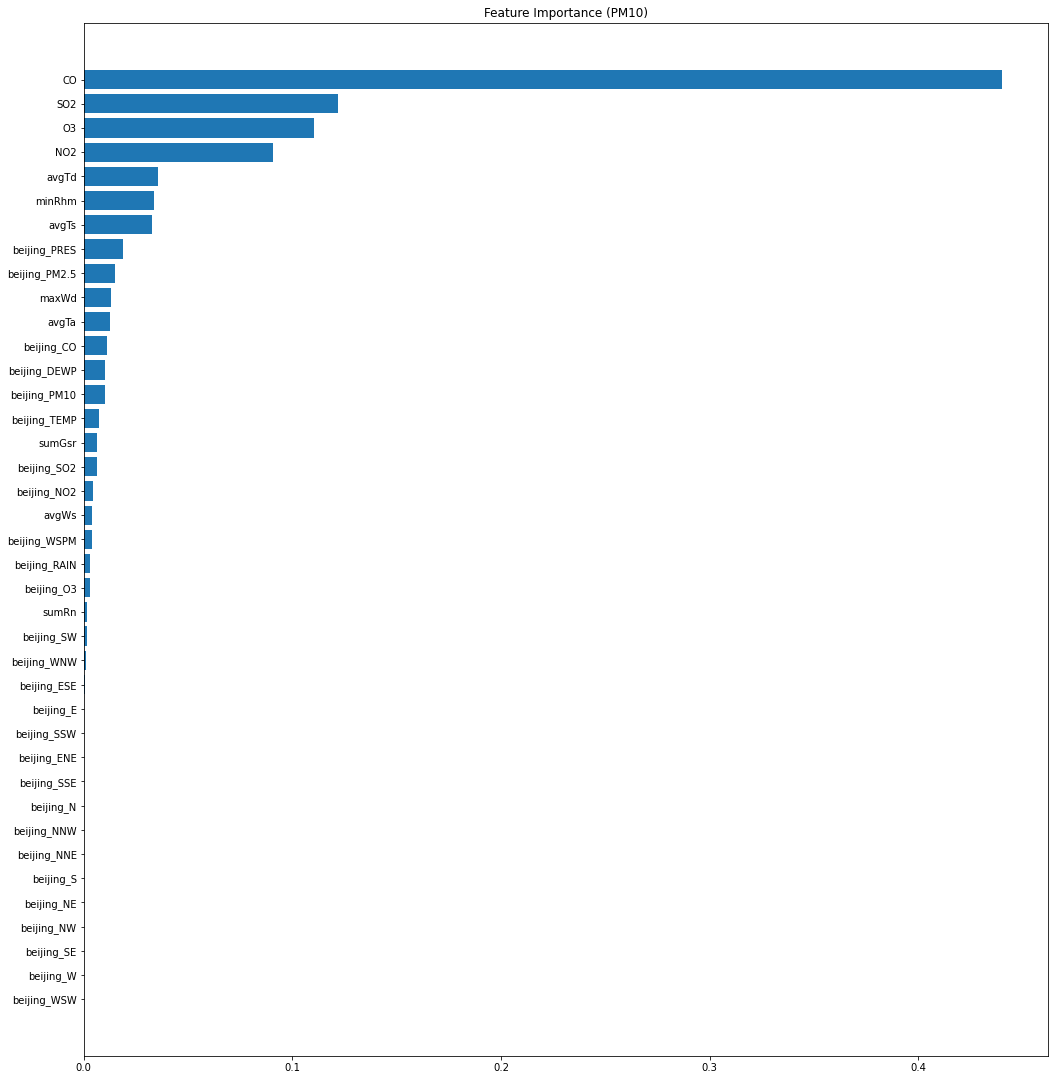

In [191]:
#draw feature importance horizontal bar graph
feature_importance = gbr_best.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(38, 19))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(std_data.columns)[sorted_idx])
plt.title('Feature Importance (PM10)')

In [187]:
#for target2 ( PM2.5)
tree_grid.fit(std_train_X2,std_train_y2)
tree_grid.best_score_
tree_grid.best_params_

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s


KeyboardInterrupt: 

In [188]:
#make decision tree with best params
best_tree = DecisionTreeRegressor(criterion="mae",max_depth=6,max_features="auto",splitter="best",random_state=1212)
#predict with test data and get score
#train dataset
best_tree.fit(std_train_X2,std_train_y2)
best_pred = best_tree.predict(std_train_X2)
mse = mean_squared_error(best_pred,std_train_y2)
print("------------std_train_mse---------------")
mse
print("------------std_train_score---------------")
best_tree.score(std_train_X2,std_train_y2)

#valid dataset
best_tree.fit(std_valid_X2,std_valid_y2)
best_valid_pred = best_tree.predict(std_valid_X2)
valid_mse = mean_squared_error(best_valid_pred,std_valid_y2)
print("------------std_valid_mse---------------")
valid_mse
print("------------std_valid_score---------------")
best_tree.score(std_valid_X2,std_valid_y2)

#test dataset
best_tree.fit(std_test_X2,std_test_y2)
best_test_pred = best_tree.predict(std_test_X2)
test_mse = mean_squared_error(best_test_pred,std_test_y2)
print("------------std_test_mse---------------")
test_mse
print("------------std_test_root_mse---------------")
rmse = np.sqrt(test_mse)
rmse
print("------------std_test_score---------------")
best_tree.score(std_test_X2,std_test_y2)

DecisionTreeRegressor(criterion='mae', max_depth=6, max_features='auto',
                      random_state=1212)

------------std_train_mse---------------


0.046623372286277734

------------std_train_score---------------


0.7667062981710959

DecisionTreeRegressor(criterion='mae', max_depth=6, max_features='auto',
                      random_state=1212)

------------std_valid_mse---------------


0.032665870825287095

------------std_valid_score---------------


0.8478534073507245

DecisionTreeRegressor(criterion='mae', max_depth=6, max_features='auto',
                      random_state=1212)

------------std_test_mse---------------


0.025685436140103997

------------std_test_root_mse---------------


0.16026676555076538

------------std_test_score---------------


0.8780155567293646

In [189]:
#gradient boosting with std scaled dataset
gbr = GradientBoostingRegressor(random_state = 131).fit(std_train_X2,std_train_y2)
gbr_pred = gbr.predict(std_test_X2)
gbr.score(std_test_X2,std_test_y2)
RMSE = np.sqrt(mean_squared_error(gbr_pred,std_test_y2))
RMSE
gbr_grid = GridSearchCV(GradientBoostingRegressor(random_state = 331),gbr_params,cv=3,n_jobs=-1,verbose = 1)
gbr_grid.fit(std_train_X2,std_train_y2)
gbr_grid.best_params_
gbr_grid.best_score_


0.7639652773927436

0.22293548223850326

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s


KeyboardInterrupt: 

GradientBoostingRegressor(learning_rate=0.01, max_features=0.5,
                          n_estimators=600, random_state=1331)

------------std_train_mse with GradientBoostingRegressor---------------


0.028049567266794705

------------std_train_score with GradientBoostingRegressor---------------


0.8596457728928508

GradientBoostingRegressor(learning_rate=0.01, max_features=0.5,
                          n_estimators=600, random_state=1331)

------------std_valid_mse with GradientBoostingRegressor---------------


0.019272179255016546

------------std_valid_score with GradientBoostingRegressor---------------


0.9102366986553143

GradientBoostingRegressor(learning_rate=0.01, max_features=0.5,
                          n_estimators=600, random_state=1331)

------------std_test_mse with GradientBoostingRegressor---------------


0.010573662790076127

------------std_test_root_mse with GradientBoostingRegressor---------------


0.1028283170633271

------------std_test_score with GradientBoostingRegressor---------------


0.9497839023739604

<AxesSubplot:>

<BarContainer object of 39 artists>

([<matplotlib.axis.YTick at 0x1947b750370>,
 [Text(0, 0.5, 'beijing_WSW'),
  Text(0, 1.5, 'beijing_W'),
  Text(0, 2.5, 'beijing_SE'),
  Text(0, 3.5, 'beijing_NW'),
  Text(0, 4.5, 'beijing_NE'),
  Text(0, 5.5, 'beijing_S'),
  Text(0, 6.5, 'beijing_NNE'),
  Text(0, 7.5, 'beijing_NNW'),
  Text(0, 8.5, 'beijing_N'),
  Text(0, 9.5, 'beijing_SSE'),
  Text(0, 10.5, 'beijing_ENE'),
  Text(0, 11.5, 'beijing_SSW'),
  Text(0, 12.5, 'beijing_E'),
  Text(0, 13.5, 'beijing_ESE'),
  Text(0, 14.5, 'beijing_WNW'),
  Text(0, 15.5, 'beijing_SW'),
  Text(0, 16.5, 'sumRn'),
  Text(0, 17.5, 'beijing_O3'),
  Text(0, 18.5, 'beijing_RAIN'),
  Text(0, 19.5, 'beijing_WSPM'),
  Text(0, 20.5, 'avgWs'),
  Text(0, 21.5, 'beijing_NO2'),
  Text(0, 22.5, 'beijing_SO2'),
  Text(0, 23.5, 'sumGsr'),
  Text(0, 24.5, 'beijing_TEMP'),
  Text(0, 25.5, 'beijing_PM10'),
  Text(0, 26.5, 'beijing_DEWP'),
  Text(0, 27.5, 'beijing_CO'),
  Text(0, 28.5, 'avgTa'),
  Text(0, 29.5, 'maxWd'),
  Text(0, 30.5, 'beijing_PM2.5'),
  Text(0, 

Text(0.5, 1.0, 'Feature Importance (PM2.5)')

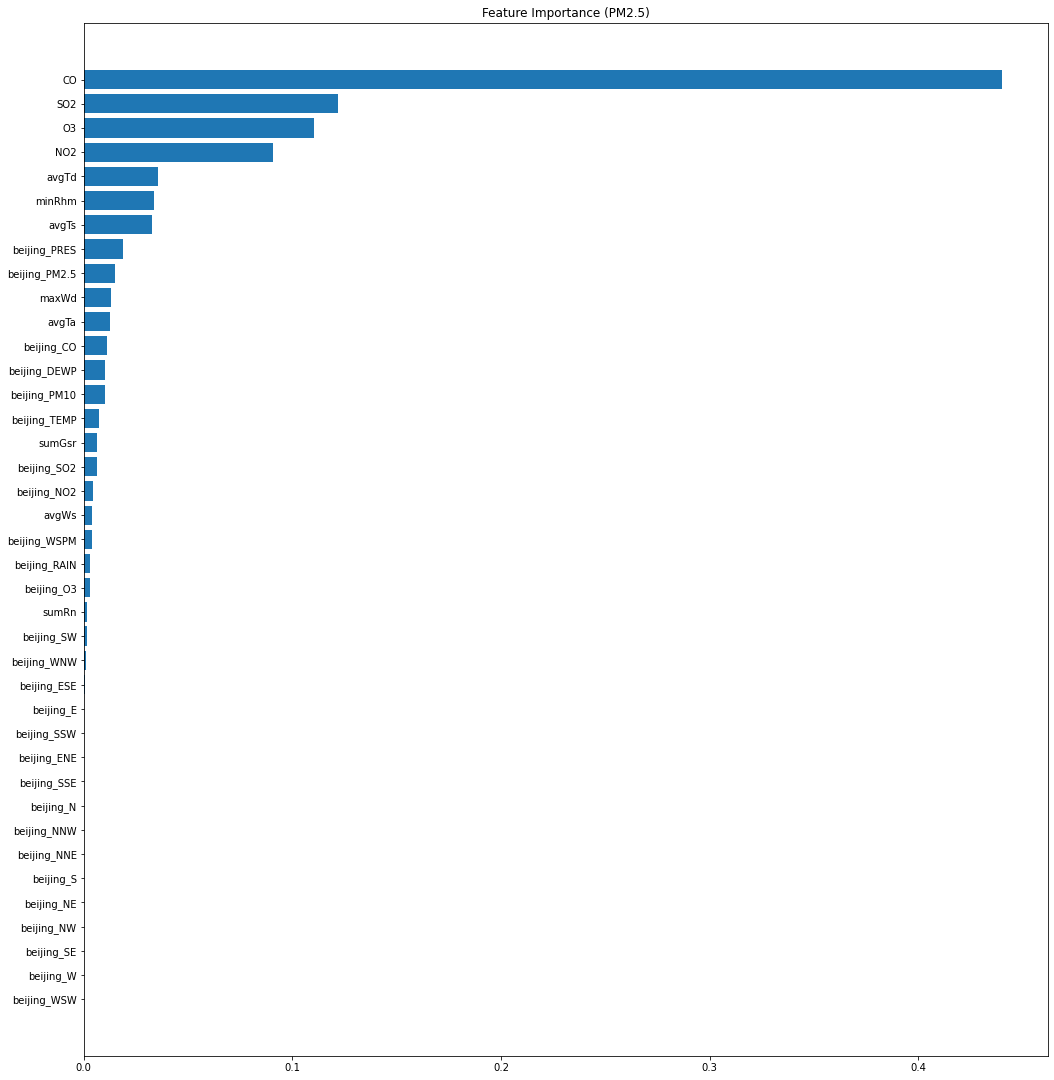

In [190]:
#make GradientBoostingRegressor with best params
gbr_best = GradientBoostingRegressor(
                             learning_rate = 0.01,max_depth = 3,max_features = 0.5,min_samples_split = 2,n_estimators = 600,
                                    random_state=1331)
#predict with test data and get score
#train dataset
gbr_best.fit(std_train_X2,std_train_y2)
best_pred =gbr_best.predict(std_train_X2)
mse = mean_squared_error(best_pred,std_train_y2)
print("------------std_train_mse with GradientBoostingRegressor---------------")
mse
print("------------std_train_score with GradientBoostingRegressor---------------")
gbr_best.score(std_train_X2,std_train_y2)

#valid dataset
gbr_best.fit(std_valid_X2,std_valid_y2)
best_valid_pred = gbr_best.predict(std_valid_X2)
valid_mse = mean_squared_error(best_valid_pred,std_valid_y2)
print("------------std_valid_mse with GradientBoostingRegressor---------------")
valid_mse
print("------------std_valid_score with GradientBoostingRegressor---------------")
gbr_best.score(std_valid_X2,std_valid_y2)

#test dataset
gbr_best.fit(std_test_X2,std_test_y2)
best_test_pred = gbr_best.predict(std_test_X2)
test_mse = mean_squared_error(best_test_pred,std_test_y2)
print("------------std_test_mse with GradientBoostingRegressor---------------")
test_mse
print("------------std_test_root_mse with GradientBoostingRegressor---------------")
rmse = np.sqrt(test_mse)
rmse
print("------------std_test_score with GradientBoostingRegressor---------------")

#draw feature importance horizontal bar graph
gbr_best.score(std_test_X2,std_test_y2)
feature_importance = gbr_best.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(38, 19))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(std_data.columns)[sorted_idx])
plt.title('Feature Importance (PM2.5)')